In [2]:
import pandas as pd
import random
import time
import math
import matplotlib.pyplot as plt
import os

In [3]:
FILE_QUERIES = '../data/query-stats/3.csv'
DIR_WORKLOADS = '../docker/workloads/'

## Functions

### Workload Gen

In [4]:
# def create_bursty(queries, num_applications, length, offset, delay, burst_interval, burst_intensity, burst_variety, duration_avg, duration_variety, rand_seed=None):
    
#     timeline = pd.DataFrame(columns=['app', 'start', 'query', 'range', 'end'])
    
#     if not rand_seed:
#         rand_seed = abs(int(time.time() * 1000) % (2**32))
#     random.seed(rand_seed)
    
#     for app in range(num_applications):
#         start = delay + offset * app
    
#         # one burst at 0 and then as many as still fit with the right starting interval
#         num_bursts = (length - start) // burst_interval + 1

#         timeline_app = pd.DataFrame(columns=['start', 'query', 'range', 'end'])

#         for burst in range(num_bursts):
#             curr_time = start + burst * burst_interval

#             random_number = random.uniform(-1, 1)
#             deviation = burst_intensity * burst_variety * random_number
#             num_queries = burst_intensity + int(round(deviation))

#             duration_min = duration_avg - (duration_avg * duration_variety)
#             duration_max = duration_avg + (duration_avg * duration_variety)
            
#             # filter the available queries for the appropriate durations and then select random ones from that
#             queries_subset = queries[(queries['duration'] >= (duration_min * 1000)) & (queries['duration'] <= (duration_max * 1000))]

#             # possibly needs some seed here as well
#             random_rows = queries_subset.sample(n=num_queries, replace=True, random_state = rand_seed + (app + 1) * (burst + 1))
            
#             timeline_burst = random_rows[['query', 'range', 'duration']]
#             timeline_burst.rename(columns={'duration': 'end'}, inplace=True)
#             timeline_burst['end'] = timeline_burst['end'] / 1000
#             timeline_burst['end'] = timeline_burst['end'] + curr_time
#             timeline_burst['start'] = curr_time

#             timeline_app = pd.concat([timeline_app, timeline_burst], ignore_index=True)
            
#         timeline_app['app'] = app
#         timeline = pd.concat([timeline, timeline_app])

#     return timeline

In [5]:
def get_filtered_queries(queries, duration, duration_var, scale_factor=1.0):
    queries_scaled = queries.copy()
    queries_scaled['duration'] = queries_scaled['duration'] * scale_factor
    duration_min = duration - (duration_var)
    duration_max = duration + (duration_var)
    return queries_scaled[(queries_scaled['duration'] >= (duration_min * 1000)) & (queries_scaled['duration'] <= (duration_max * 1000))]

In [6]:
def create_bursty(queries, num_apps:int, burst_count:int, burst_interval, query_duration, burst_intensity:int,
                   burst_interval_var=0.0, query_duration_var=5.0, burst_intensity_var=0, 
                   query_start_var=0.0, initial_delay=0.0, query_scale_factor=1.0, rand_seed=None):

    """
    Generate a bursty workload timeline based on the given parameters.

    Parameters
    ----------
    queries : dataframe with columns [query, 'range', 'duration']
        A DataFrame containing all available queries including expected execution durations
    num_apps : int
        Number of apps.
    burst_count : int
        Number of bursts per app.
    burst_interval : int or float
        Time interval between bursts (in seconds)
    query_duration : int or float
        Desired duration of queries (in seconds)
    burst_intensity : int
        Number of queries per burst.
    burst_interval_var : float
        Variability of burst intervals (in seconds)
    query_duration_var : float
        Variability of query durations (in seconds)
    burst_intensity_var : int
        Variability of burst intensity.
    query_start_var : float
        Possible delay of query start times (in seconds)
    initial_delay : float
        Initial delay of workload.
    rand_seed : int
        Seed for random number gen.
    """
    
    timeline = pd.DataFrame(columns=['app', 'start', 'query', 'range', 'end'])

    if not rand_seed:
        rand_seed = int(time.time() * 1000) % (2**32)
    print(f'Bursty for {num_apps} apps with seed: {rand_seed}')
    random.seed(rand_seed)

    queries_subset = get_filtered_queries(queries, query_duration, query_duration_var, query_scale_factor)
    
    for app in range(num_apps):
        start_time = initial_delay + burst_interval * app

        timeline_app = pd.DataFrame(columns=['start', 'duration', 'query', 'range'])

        for burst in range(burst_count):
            # FIXME: this can get negative for the first burst
            burst_start_deviation = random.uniform(-1, 1) * burst_interval_var
            curr_time = start_time + burst * burst_interval * num_apps + burst_start_deviation

            burst_intensity_deviation = random.uniform(-1, 1) * burst_intensity_var
            num_queries = burst_intensity + int(round(burst_intensity_deviation))
            # possibly needs some seed here as well
            rand_seed_burst = (rand_seed + (app + 1) * (burst + 1)) % (2**32)
            random_queries = queries_subset.sample(n=num_queries, replace=True, random_state=rand_seed_burst)
            
            timeline_burst = random_queries[['query', 'range', 'duration']]
            timeline_burst['start'] = curr_time
            timeline_burst['start'] = timeline_burst['start'].apply(lambda x: x + random.uniform(0, query_start_var))
            timeline_burst['duration'] = timeline_burst['duration'] / 1000
            # timeline_burst['end'] = timeline_burst['duration'] + timeline_burst['start']

            timeline_app = pd.concat([timeline_app, timeline_burst], ignore_index=True)
            
        timeline_app['app'] = app
        timeline = pd.concat([timeline, timeline_app])

    return timeline

In [7]:
def create_bursty2(queries, num_apps:int, app_offset, burst_count:int, burst_interval, query_duration, burst_intensity:int,
                   query_start_offset=0.0,
                   burst_start_var=0.0, query_duration_var=5.0, burst_intensity_var=0, 
                   query_start_var=0.0, initial_delay=0.0, warm_up=0, query_scale_factor=1.0, rand_seed=None):
    
    timeline = pd.DataFrame(columns=['app', 'start', 'duration', 'query', 'range'])

    if rand_seed == None:
        rand_seed = int(time.time() * 1000) % (2**32)
    print(f'Bursty for {num_apps} apps with seed: {rand_seed}')
    random.seed(rand_seed)
    
    queries_subset = get_filtered_queries(queries, query_duration, query_duration_var, query_scale_factor)
    
    for app in range(num_apps):
            
        start_time = initial_delay + app_offset * app

        timeline_app = None

        if warm_up > 0:
            warm_up_queries = queries_subset.sample(n=warm_up, replace=True, random_state=rand_seed + (app))
            timeline_app = warm_up_queries[['query', 'range', 'duration']].copy()
            timeline_app['start'] = 0
            timeline_app['duration'] = timeline_app['duration'] / 1000
        else:
            pd.DataFrame(columns=['start', 'duration', 'query', 'range'])

        for burst in range(burst_count):

            burst_start_deviation = random.uniform(-1, 1) * burst_start_var
            curr_time = start_time + burst * burst_interval + burst_start_deviation
            if curr_time < initial_delay: curr_time = initial_delay

            burst_intensity_deviation = random.uniform(-1, 1) * burst_intensity_var
            num_queries = burst_intensity + int(round(burst_intensity_deviation))
            # possibly needs some seed here as well
            rand_seed_burst = (rand_seed + (app + 1) * (burst + 1)) % (2**32)
            random_queries = queries_subset.sample(n=num_queries, replace=True, random_state=rand_seed_burst)
            
            timeline_burst = random_queries[['query', 'range', 'duration']].copy().reset_index()
            timeline_burst['start'] = (timeline_burst.index * query_start_offset) + curr_time
            timeline_burst['start'] = timeline_burst['start'].apply(lambda x: x + random.uniform(0, query_start_var))
            timeline_burst['duration'] = timeline_burst['duration'] / 1000
            # timeline_burst['end'] = timeline_burst['duration'] + timeline_burst['start']

            timeline_app = pd.concat([timeline_app, timeline_burst], ignore_index=True)
            
        timeline_app['app'] = app
        timeline = pd.concat([timeline, timeline_app])

    return timeline

In [8]:
def create_random(queries, num_apps:int, duration, query_duration_min, query_duration_max, intensity, intensity_var=0, initial_delay=0, query_scale_factor=1.0, rand_seed=None):
    timeline = pd.DataFrame(columns=['app', 'start', 'duration', 'query', 'range'])

    if not rand_seed:
        rand_seed = int(time.time() * 1000) % (2**32)
    print(f'Random for {num_apps} apps with seed: {rand_seed}')
    random.seed(rand_seed)

    # TODO: implement scale factor
    queries_subset = queries[(queries['duration'] >= (query_duration_min * 1000)) & (queries['duration'] <= (query_duration_max * 1000))].copy()
    end_time = duration + initial_delay

    for app in range(num_apps):

        num_queries = int(round((intensity + int(round(random.uniform(-1, 1) * intensity_var))) * (duration / 60)))
        rand_seed_app = (rand_seed * (app + 1)) % (2 ** 32)
        random_queries = queries_subset.sample(n=num_queries, replace=True, random_state=rand_seed_app)
        timeline_app = random_queries[['query', 'range', 'duration']].copy()
        timeline_app['start'] = [random.uniform(initial_delay, end_time) for _ in range(num_queries)]
        # timeline_app.rename(columns={'duration': 'end'}, inplace=True)
        # timeline_app['end'] = timeline_app['end'] / 1000 + timeline_app['start']
        timeline_app['duration'] = timeline_app['duration'] / 1000
        timeline_app['app'] = app
        timeline = pd.concat([timeline, timeline_app], ignore_index=True)

    return timeline

In [9]:
def create_constant(queries, num_apps:int, duration, query_duration, query_interval, app_offset, query_duration_var=5.0, query_interval_var=0.0, initial_delay=0.0, warm_up=0, query_scale_factor=1.0, rand_seed=None):
    
    timeline = pd.DataFrame(columns=['app', 'start', 'duration', 'query', 'range'])

    if rand_seed == None:
        rand_seed = int(curr_time.time() * 1000) % (2**32)
    print(f'Constant for {num_apps} apps with seed: {rand_seed}')
    random.seed(rand_seed)

    queries_subset = get_filtered_queries(queries, query_duration, query_duration_var, query_scale_factor)
    queries_subset['duration'] = queries_subset['duration'] / 1000

    for app in range(num_apps):

        timeline_app = None

        if warm_up > 0:
            warm_up_queries = queries_subset.sample(n=warm_up, replace=True, random_state=rand_seed + (app))
            timeline_app = warm_up_queries[['query', 'range', 'duration']].copy()
            timeline_app['start'] = 0
        else:
            timeline_app = pd.DataFrame(columns=['start', 'duration', 'query', 'range'])

        curr_time = initial_delay + app_offset * app

        while curr_time < duration + initial_delay:
            query = queries_subset.sample(n=1, random_state=int(rand_seed + app + curr_time))
            query = query[['query', 'range', 'duration']]
            query['start'] = curr_time
            timeline_app = pd.concat([timeline_app, query])

            curr_time += query_interval + random.uniform(-1, 1) * query_interval_var
        
        timeline_app['app'] = app
        timeline = pd.concat([timeline, timeline_app])

    return timeline

In [10]:
def create_constant2(queries, num_apps:int, duration, query_duration, intensity, app_offset, query_duration_var=5.0, query_interval_var=0.0, query_duration_buffer=0.0, initial_delay=0.0, warm_up=0, query_scale_factor=1.0, rand_seed=None):
    
    timeline = pd.DataFrame(columns=['app', 'start', 'duration', 'query', 'range'])

    if rand_seed == None:
        rand_seed = int(curr_time.time() * 1000) % (2**32)
    print(f'Constant for {num_apps} apps with seed: {rand_seed}')
    random.seed(rand_seed)

    queries_subset = get_filtered_queries(queries, query_duration, query_duration_var, query_scale_factor)
    queries_subset['duration'] = queries_subset['duration'] / 1000

    for app in range(num_apps):

        app_intensity = None

        if type(intensity) == list:
            app_intensity = intensity[app]
        else:
            app_intensity = intensity

        timeline_app = None

        if warm_up > 0:
            warm_up_queries = queries_subset.sample(n=warm_up, replace=True, random_state=rand_seed + (app))
            timeline_app = warm_up_queries[['query', 'range', 'duration']].copy()
            timeline_app['start'] = 0
        else:
            timeline_app = pd.DataFrame(columns=['start', 'duration', 'query', 'range'])

        curr_time = initial_delay + app_offset * app

        while curr_time < duration + initial_delay:
            query = queries_subset.sample(n=1, random_state=int(rand_seed + app + curr_time))
            query = query[['query', 'range', 'duration']]
            query['start'] = curr_time
            timeline_app = pd.concat([timeline_app, query])

            curr_time += (query['duration'].mean() + query_duration_buffer) / app_intensity + random.uniform(-1, 1) * query_interval_var
        
        timeline_app['app'] = app
        timeline = pd.concat([timeline, timeline_app])

    return timeline

### Workload Visualization/Saving

In [11]:
def get_load_changes(timeline):
    if 'start' not in timeline.columns:
        raise ValueError("Dataframe must include a 'start' column")

    if 'end' not in timeline.columns:
        if 'duration' not in timeline.columns:
            raise ValueError("Dataframe must include either a 'end' or 'duration' column")
        timeline = timeline.copy()
        timeline['end'] = timeline['start'] + timeline['duration']

    start_times = [(time, +1) for time in timeline['start']]
    end_times = [(int(math.ceil(time)), -1) for time in timeline['end']]

    return sorted(start_times + end_times)

def get_load_timeline(load_changes):
    load = 0
    load_timeline = []
    if len(load_changes) > 0:
        last_time = 0
        for time, delta in load_changes:
            if (time != last_time):
                load_timeline.append((last_time, load))
                if (time - last_time > 1):
                    load_timeline.append((time - 1, load))
                last_time = time
            load += delta
        load_timeline.append((last_time, load))
    # print(load_timeline)
    return load_timeline


def plot_timeline(timeline: pd.DataFrame, rolling=None):

    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(20)
    ax.set_xlabel(f'Time in Seconds')
    ax.set_ylabel('Active Queries')

    for app in timeline['app'].unique():

        load_timeline = get_load_timeline(get_load_changes(timeline[timeline['app'] == app]))
        df_load = pd.DataFrame(load_timeline, columns=['time', 'activeQueries'])
        df_load = df_load.set_index(pd.to_datetime(df_load['time'], unit='s'))

        # possibly do something to make all timelines end at the same point (some currently end earlier)

        ax.plot(df_load['time'], df_load['activeQueries'], label=f'App {app}')
    
    if rolling != None:
        load_timeline = get_load_timeline(get_load_changes(timeline))
        df_load = pd.DataFrame(load_timeline, columns=['time', 'activeQueries'])
        df_load = df_load.set_index(pd.to_datetime(df_load['time'], unit='s'))
        df_load = df_load.resample('1S').ffill()
        df_load['rolling_average'] = df_load['activeQueries'].rolling(window=f'{rolling}s').mean()
        ax.plot(df_load['time'], df_load['rolling_average'], label=f'Combined (RW={rolling})', linestyle='dashed')

    ax.legend()
    return

In [12]:
def print_timeline_info(timeline): 
    print(f'Unique query types: {len(timeline["query"].unique())}')
    print(f'Unique queries: {timeline[["query", "range"]].drop_duplicates().shape[0]}')
    print(f'Shortest: {timeline["duration"].min():.3f}s, Median: {timeline["duration"].median():.3f}, Longest: {timeline["duration"].max():.3f}s')


In [13]:
def plot_durations(workload):
    plt.figure()  # Create a new plot
    plt.boxplot(workload['duration'], showfliers=True)
    plt.xlabel('Duration')
    plt.ylabel('Seconds')
    plt.title('Boxplot of Duration')
    plt.show()

In [14]:
def save_timeline(timeline: pd.DataFrame, filename, dir=DIR_WORKLOADS):
    timeline = timeline.copy().sort_values(['start', 'app'])
    timeline['start'] = (timeline['start'] * 1000).astype(int)
    timeline['duration'] = (timeline['duration'] * 1000).astype(int)
    path = f'{dir}/{filename}.csv'
    timeline[['app', 'start', 'duration', 'query', 'range']].to_csv(path, header=True, index=False)
    print(f'Saved to "{path}"')

In [15]:
def gen_plot_and_save_timelines(generator, num_apps:list, filename, dir=DIR_WORKLOADS, rolling=None):
    timelines = [(n, generator(n))
    for n in num_apps]

    for n, timeline in timelines:
        plot_timeline(timeline, rolling)
        save_timeline(timeline, dir, f'{filename}_{n}')

## Get Query Data

In [16]:
queries = pd.read_csv(FILE_QUERIES)

print(f'Read {len(queries)} queries with average durations from {queries["duration"].min() / 1000:.3f} to {queries["duration"].max() / 1000:.3f} seconds.')
query_min = queries.loc[queries['duration'].idxmin()]
query_max = queries.loc[queries['duration'].idxmax()]
print(f'Shortest query is query {query_min["query"]} with range "{query_min["range"]}"')
print(f'Longest query is query {query_max["query"]} with range "{query_max["range"]}"')

Read 91 queries with average durations from 2.228 to 119.063 seconds.
Shortest query is query q7 with range "d_date between cast('2000-04-30' as date) and ((cast('2000-04-30' as date) + interval '4' day))"
Longest query is query q10 with range "d_year = 2000 or d_year = 2001"


## Generate Workloads

In [17]:
DEF_SCALE_FACTOR=5.5

### Bursty (Overlapping, Spaced, Spaced Long)

Bursty for 2 apps with seed: 0
Bursty for 2 apps with seed: 0
Bursty for 2 apps with seed: 0
OVERLAPPTING 2
Unique query types: 5
Unique queries: 12
Shortest: 45.807s, Median: 51.025, Longest: 61.992s
SPACED 2
Unique query types: 5
Unique queries: 12
Shortest: 45.807s, Median: 51.025, Longest: 61.992s
SPACED_LONG 2
Unique query types: 5
Unique queries: 12
Shortest: 45.807s, Median: 51.025, Longest: 61.992s
Saved to "../docker/workloads//bursty-overlapping-i10bl60bb5sf550d1800_2.csv"
Saved to "../docker/workloads//bursty-spaced-ii10bl60bb5sf550d1800_2.csv"
Saved to "../docker/workloads//bursty-spaced-long-i10bl90bb35sf550d1800_2.csv"
Bursty for 3 apps with seed: 0
Bursty for 3 apps with seed: 0
Bursty for 3 apps with seed: 0
OVERLAPPTING 3
Unique query types: 5
Unique queries: 12
Shortest: 45.807s, Median: 51.025, Longest: 61.992s
SPACED 3
Unique query types: 5
Unique queries: 12
Shortest: 45.807s, Median: 51.025, Longest: 61.992s
SPACED_LONG 3
Unique query types: 5
Unique queries: 12
S

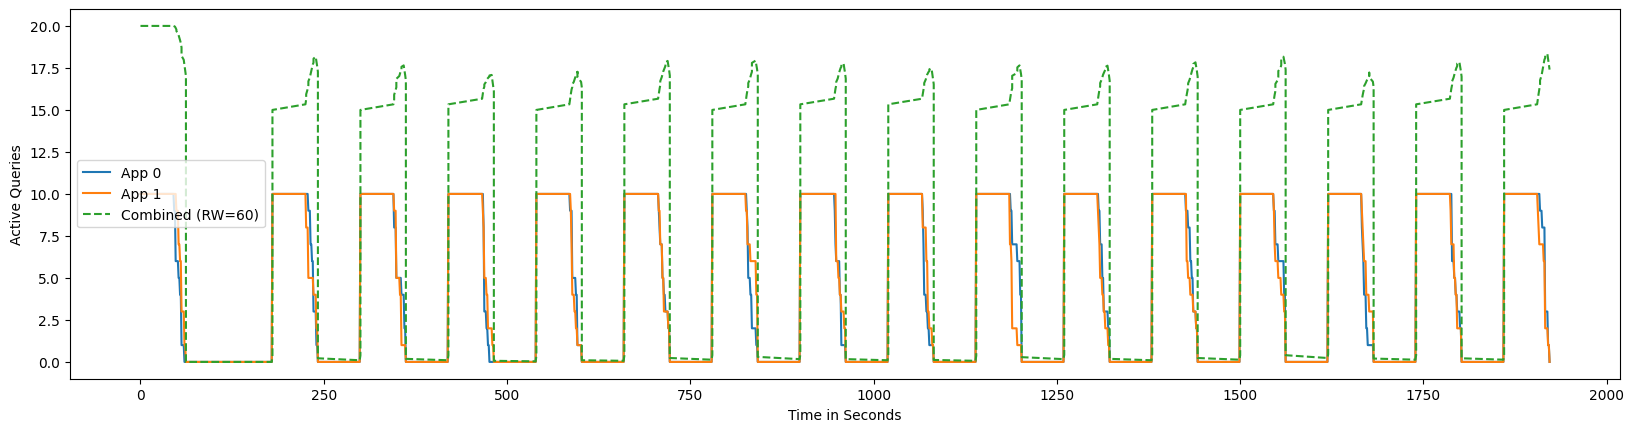

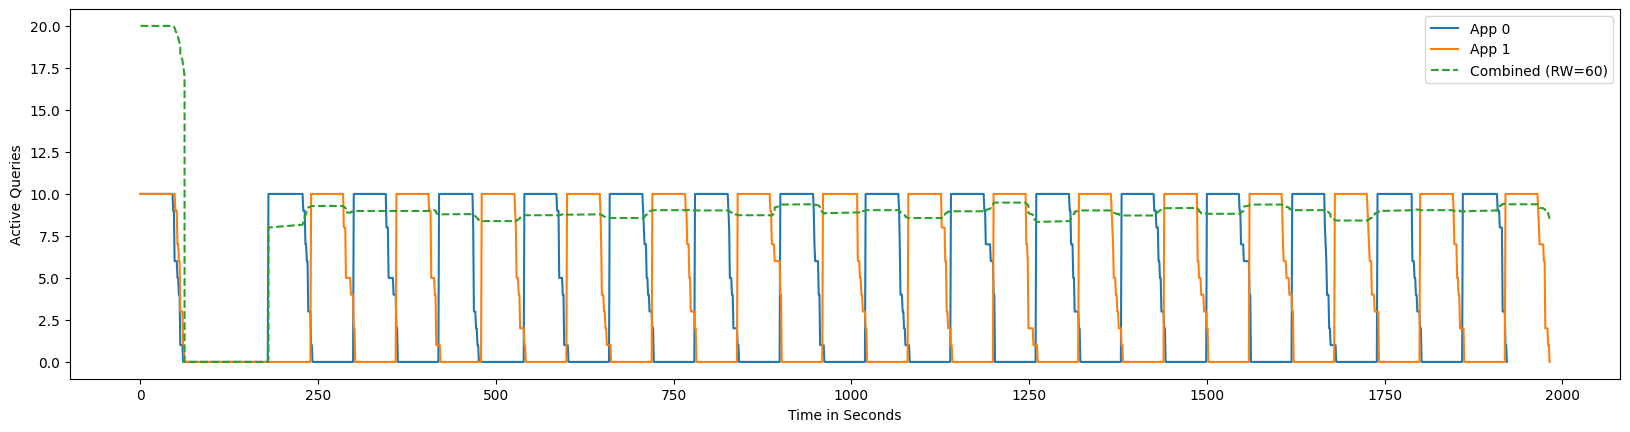

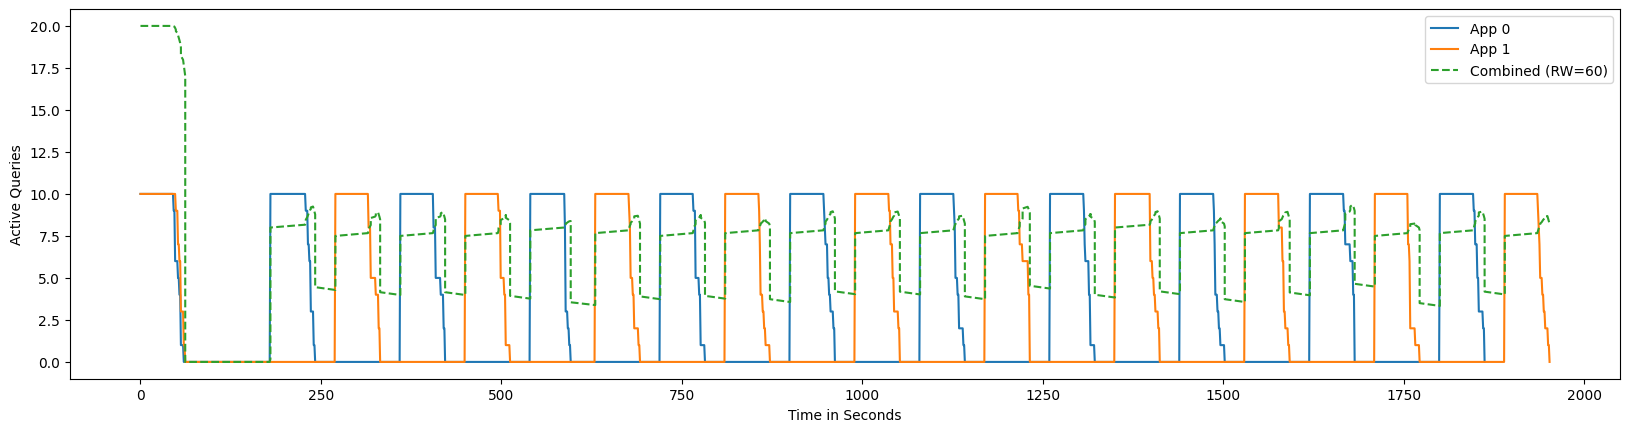

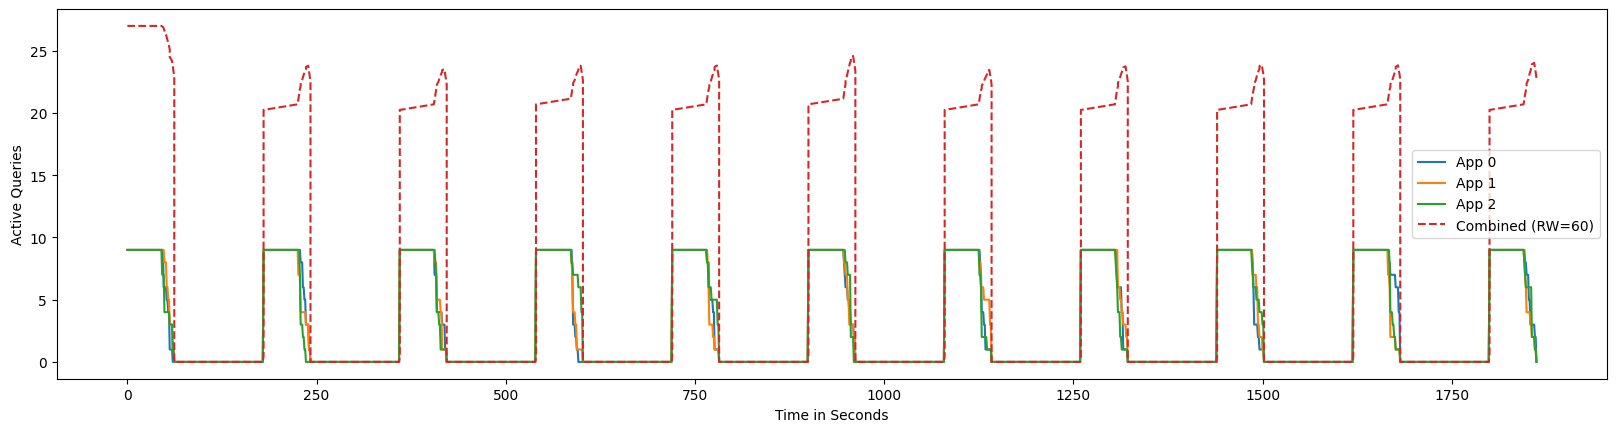

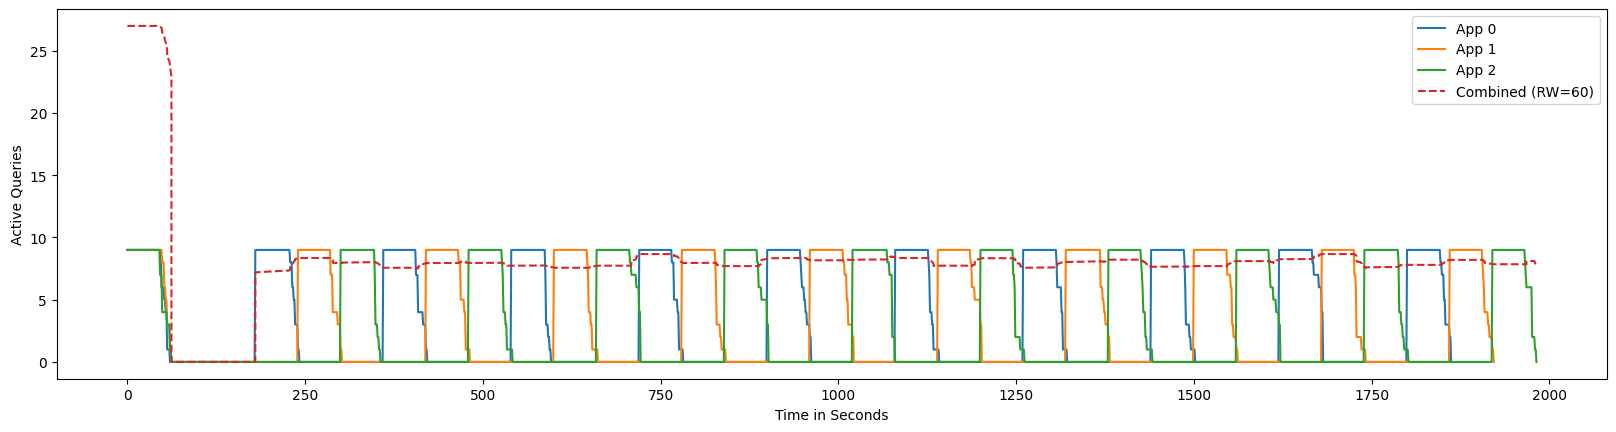

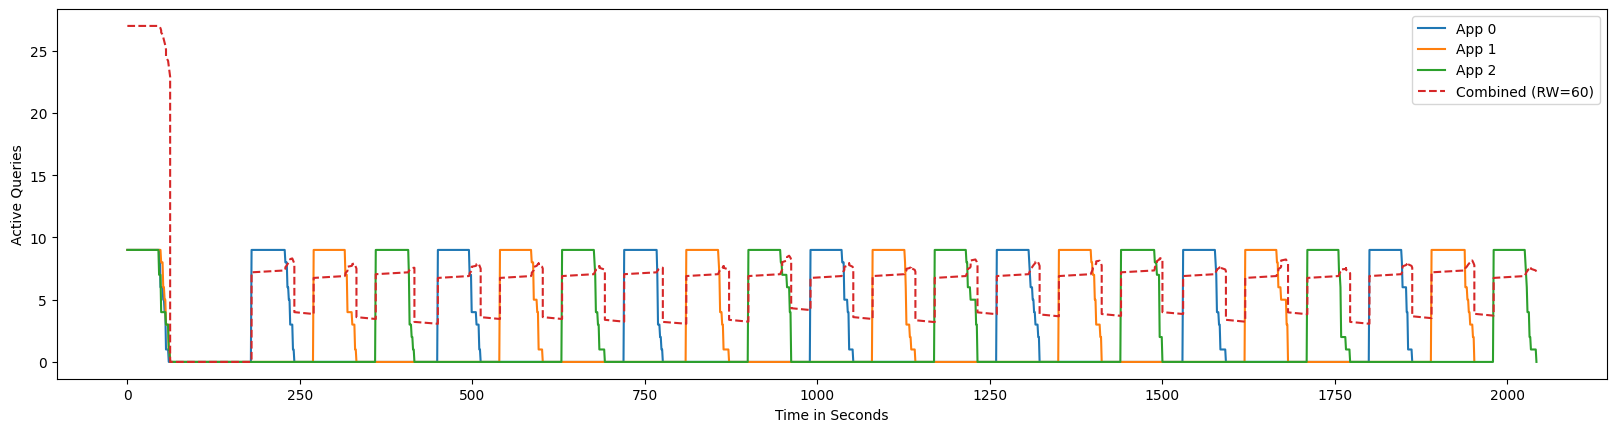

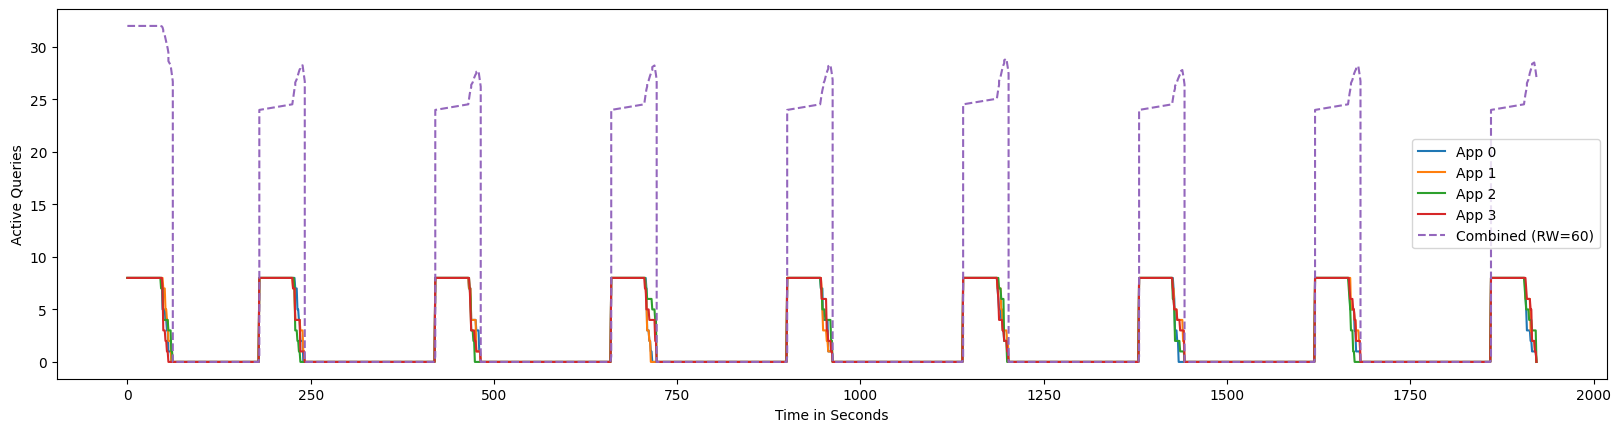

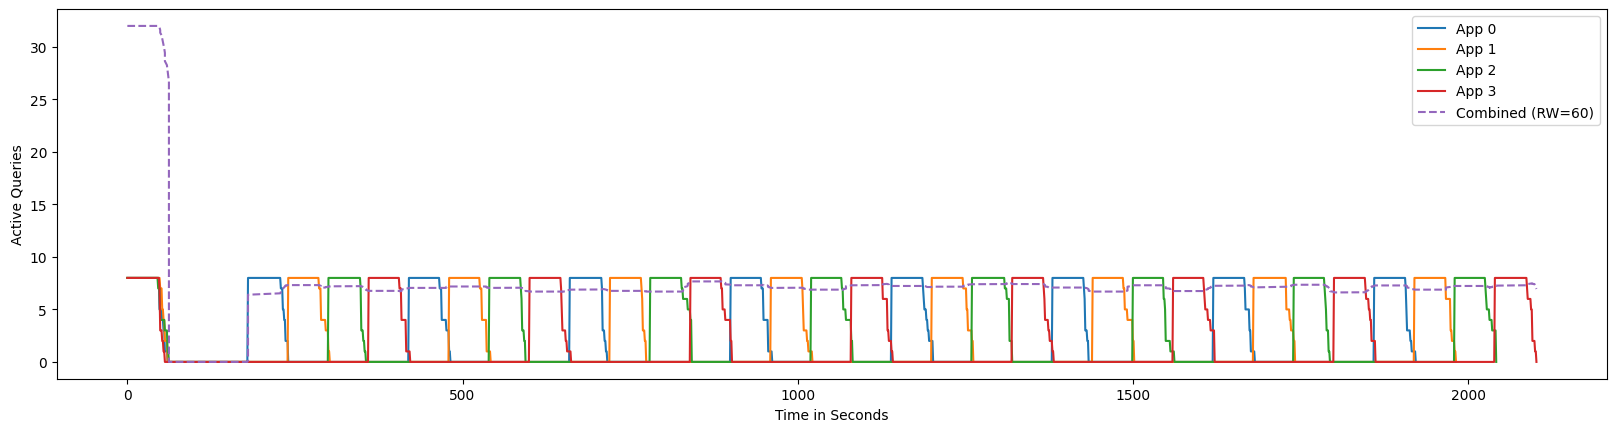

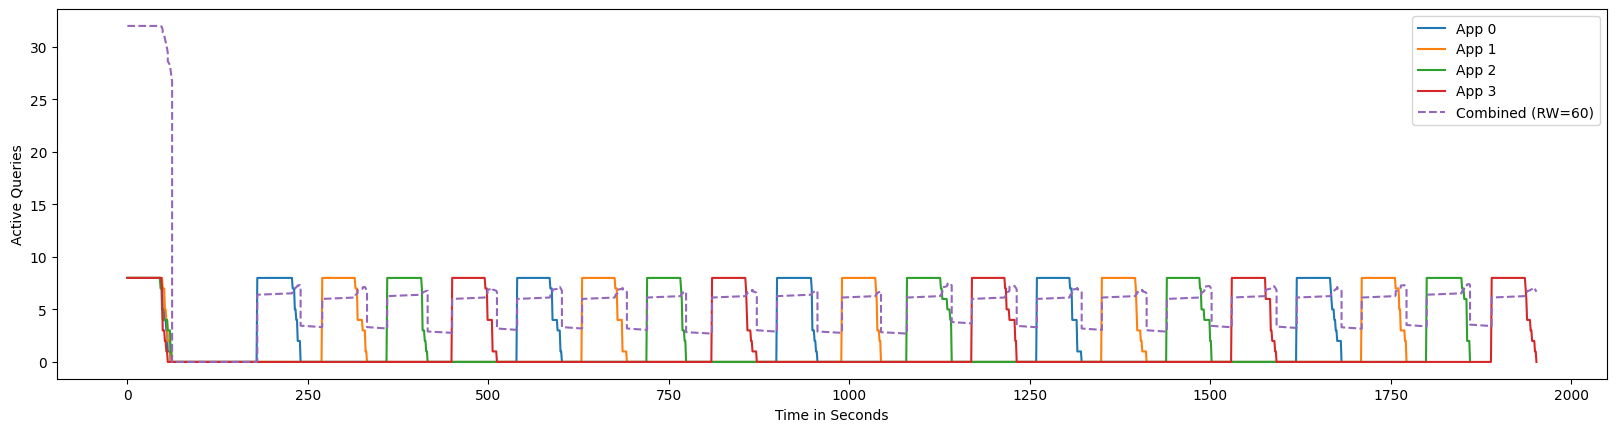

In [18]:
BURST_LEN = 60
BURST_SPACED_LONG_BUFFER = 30
BURST_BUFFER = 5
BURST_INTENSITY = {
    2: 10,
    3: 9,
    4: 8,
}
DURATION_VAR = 10
TOTAL_LEN = 1800
QUERY_START_OFFSET = 0
QUERY_START_VAR = 0
QUERY_SCALE_FACTOR = {
    2: DEF_SCALE_FACTOR,
    3: DEF_SCALE_FACTOR,
    4: DEF_SCALE_FACTOR
}

def get_id(intensity, burst_len, burst_buffer, scale_factor, total_len, num_apps):
    return f'i{intensity}bl{burst_len}bb{burst_buffer}sf{scale_factor * 100:.0f}d{total_len}_{num_apps}'

for n in range(2, 5):

    bursty_overlapping = create_bursty2(
        queries, 
        num_apps=n,
        app_offset=0,
        burst_count=int(math.ceil(TOTAL_LEN / (n * BURST_LEN))),
        burst_interval=n * BURST_LEN,
        query_duration=BURST_LEN - BURST_BUFFER,
        burst_intensity=BURST_INTENSITY[n],
        query_start_offset=QUERY_START_OFFSET,
        burst_start_var=0,
        query_duration_var=DURATION_VAR,
        burst_intensity_var=0,
        query_start_var=QUERY_START_VAR,
        query_scale_factor=QUERY_SCALE_FACTOR[n],
        warm_up=BURST_INTENSITY[n],
        initial_delay=BURST_LEN * 3,
        rand_seed=0
    )

    bursty_spaced = create_bursty2(
        queries, 
        num_apps=n,
        app_offset=BURST_LEN,
        burst_count=int(math.ceil(TOTAL_LEN / (n * BURST_LEN))),
        burst_interval=n * BURST_LEN,
        query_duration=BURST_LEN - BURST_BUFFER,
        burst_intensity=BURST_INTENSITY[n],
        query_start_offset=QUERY_START_OFFSET,
        burst_start_var=0,
        query_duration_var=DURATION_VAR,
        burst_intensity_var=0,
        query_start_var=QUERY_START_VAR,
        warm_up=BURST_INTENSITY[n],
        initial_delay=BURST_LEN * 3,
        query_scale_factor=QUERY_SCALE_FACTOR[n],
        rand_seed=0
    )

    burst_len_spaced_long = BURST_LEN + BURST_SPACED_LONG_BUFFER

    bursty_spaced_long = create_bursty2(
        queries, 
        num_apps=n,
        app_offset=burst_len_spaced_long,
        burst_count=int(math.ceil(TOTAL_LEN / (n * burst_len_spaced_long))),
        burst_interval=n * burst_len_spaced_long,
        query_duration=BURST_LEN - BURST_BUFFER,
        burst_intensity=BURST_INTENSITY[n],
        query_start_offset=QUERY_START_OFFSET,
        burst_start_var=0,
        query_duration_var=DURATION_VAR,
        burst_intensity_var=0,
        query_start_var=QUERY_START_VAR,
        warm_up=BURST_INTENSITY[n],
        initial_delay=BURST_LEN * 3,
        query_scale_factor=QUERY_SCALE_FACTOR[n],
        rand_seed=0
    )
    
    print(f'OVERLAPPTING {n}')
    print_timeline_info(bursty_overlapping)
    print(f'SPACED {n}')
    print_timeline_info(bursty_spaced)
    print(f'SPACED_LONG {n}')
    print_timeline_info(bursty_spaced_long)

    # plot_durations(bursty_spaced)

    plot_timeline(bursty_overlapping, 60)    
    plot_timeline(bursty_spaced, 60)    
    plot_timeline(bursty_spaced_long, 60)    
    
    save_timeline(
        bursty_overlapping, 
        f'bursty-overlapping-{get_id(BURST_INTENSITY[n], BURST_LEN, BURST_BUFFER, QUERY_SCALE_FACTOR[n], TOTAL_LEN, n)}')
    save_timeline(
        bursty_spaced, 
        f'bursty-spaced-i{get_id(BURST_INTENSITY[n], BURST_LEN, BURST_BUFFER, QUERY_SCALE_FACTOR[n], TOTAL_LEN, n)}')
    save_timeline(
        bursty_spaced_long, 
        f'bursty-spaced-long-{get_id(BURST_INTENSITY[n], burst_len_spaced_long, BURST_BUFFER+BURST_SPACED_LONG_BUFFER, QUERY_SCALE_FACTOR[n],TOTAL_LEN, n)}')

### Constant

Constant for 2 apps with seed: 0
Unique query types: 5
Unique queries: 12
Shortest: 45.807s, Median: 53.931, Longest: 61.992s


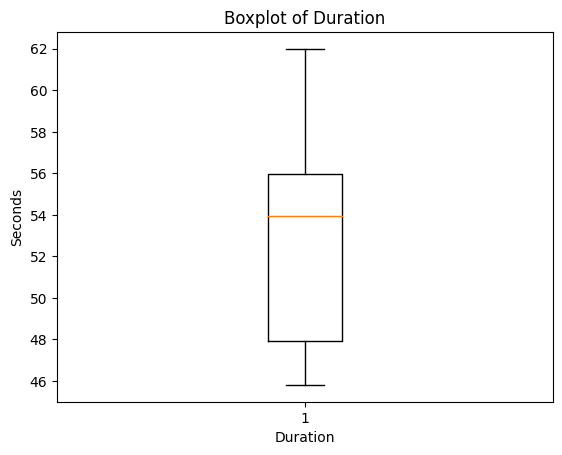

Saved to "../docker/workloads//constant-i10qd60sf550d1800_2.csv"
Constant for 3 apps with seed: 0
Unique query types: 5
Unique queries: 12
Shortest: 45.807s, Median: 51.025, Longest: 61.992s


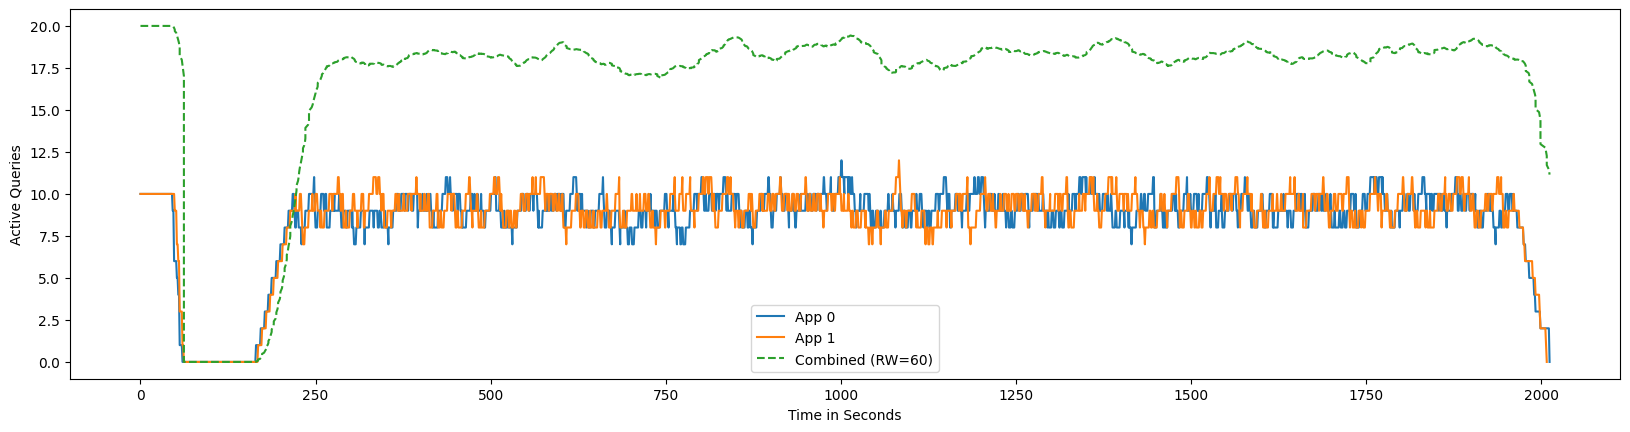

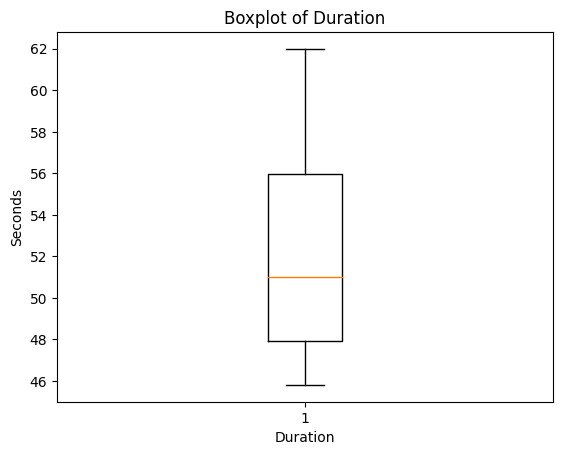

Saved to "../docker/workloads//constant-i6qd60sf550d1800_3.csv"
Constant for 4 apps with seed: 0
Unique query types: 5
Unique queries: 12
Shortest: 45.807s, Median: 51.025, Longest: 61.992s


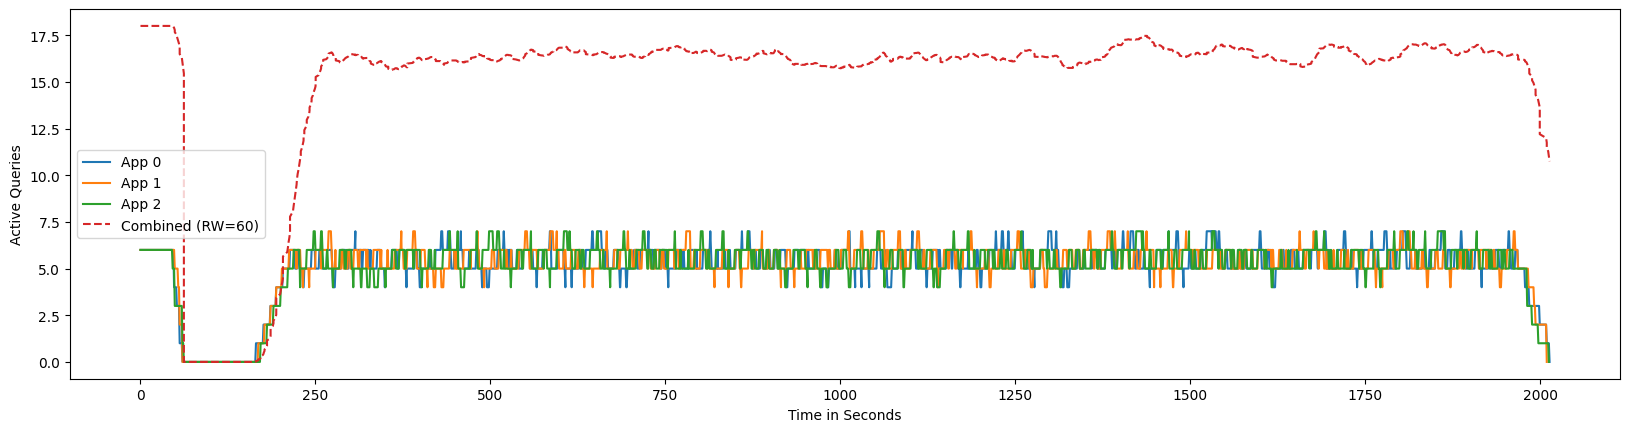

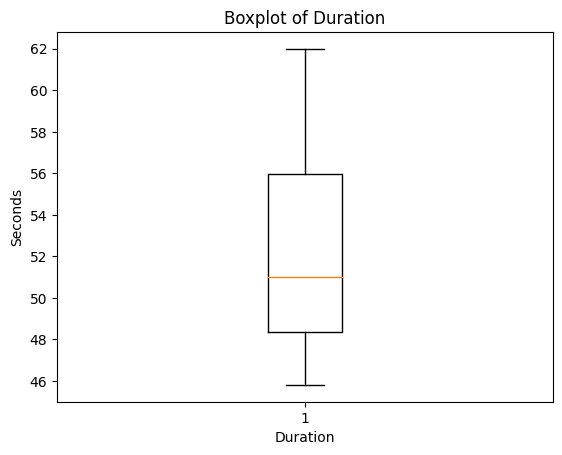

Saved to "../docker/workloads//constant-i4qd60sf550d1800_4.csv"


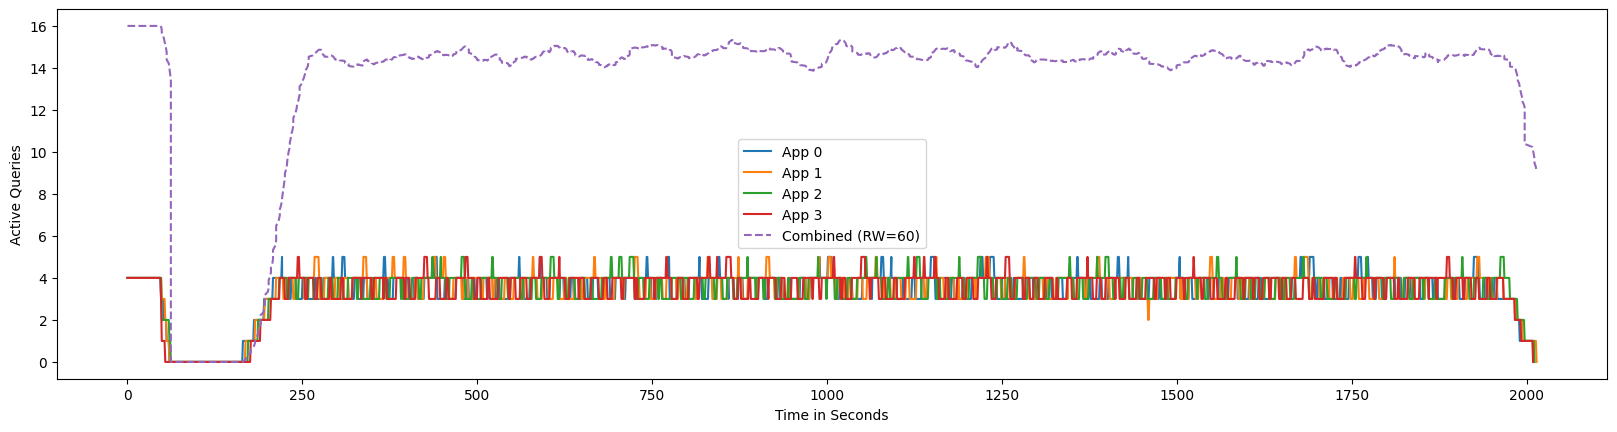

In [19]:
QUERY_DURATION = 55
QUERY_DURATION_BUFFER = 5
INTENSITY = {
    2: 10,
    3: 6,
    4: 4
}
QUERY_SCALE_FACTOR=DEF_SCALE_FACTOR
DURATION=1800

for n in range(2, 5):
    constant = create_constant2(
        queries,
        num_apps=n,
        duration=DURATION,
        query_duration=QUERY_DURATION,
        query_duration_buffer=QUERY_DURATION_BUFFER,
        intensity=INTENSITY[n],
        app_offset=(QUERY_DURATION + QUERY_DURATION_BUFFER) / n / INTENSITY[n],
        query_duration_var=10,
        query_interval_var=1,
        initial_delay=3*QUERY_DURATION,
        warm_up=INTENSITY[n],
        query_scale_factor=QUERY_SCALE_FACTOR,
        rand_seed=0
    )
    print_timeline_info(constant)
    plot_durations(constant)
    plot_timeline(constant, rolling=60)
    save_timeline(constant, f'constant-i{INTENSITY[n]}qd{QUERY_DURATION + QUERY_DURATION_BUFFER}sf{QUERY_SCALE_FACTOR * 100:.0f}d{DURATION}_{n}')


### Constant Mixed

Constant for 2 apps with seed: 0
Unique query types: 5
Unique queries: 12
Shortest: 45.807s, Median: 53.931, Longest: 61.992s


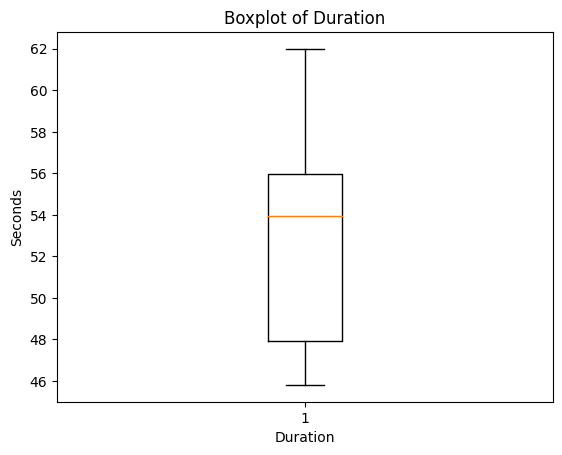

Saved to "../docker/workloads//constant-mixed-i20l60sf550d1800_2.csv"
Constant for 3 apps with seed: 0
Unique query types: 5
Unique queries: 12
Shortest: 45.807s, Median: 53.931, Longest: 61.992s


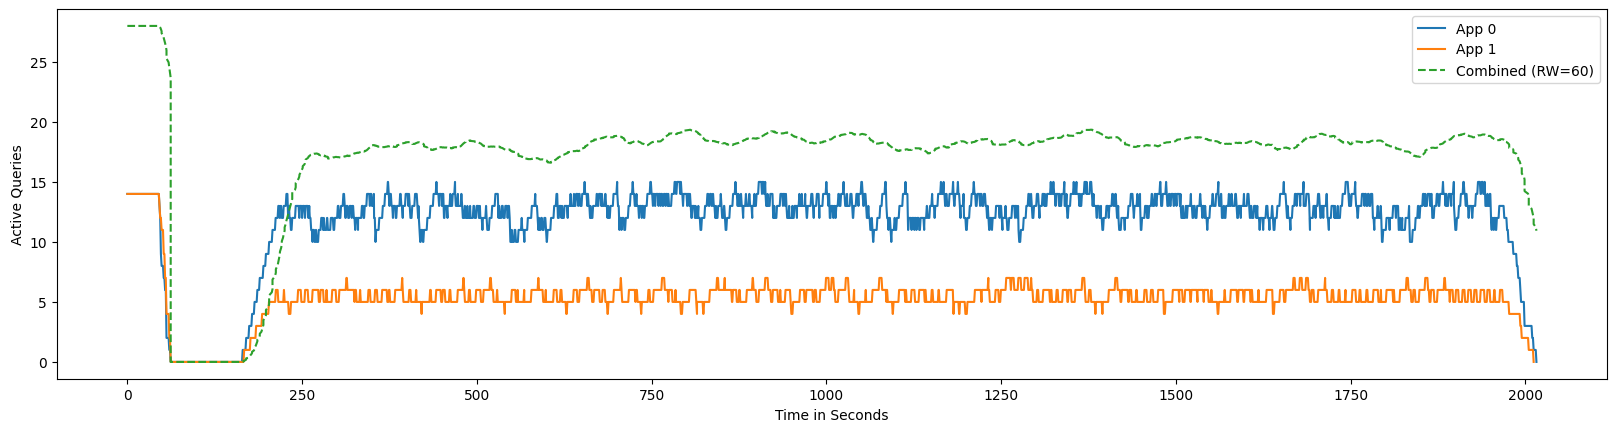

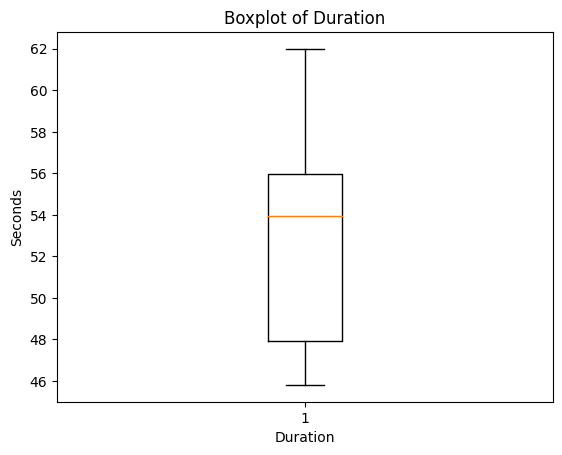

Saved to "../docker/workloads//constant-mixed-i18l60sf550d1800_3.csv"
Constant for 4 apps with seed: 0
Unique query types: 5
Unique queries: 12
Shortest: 45.807s, Median: 51.025, Longest: 61.992s


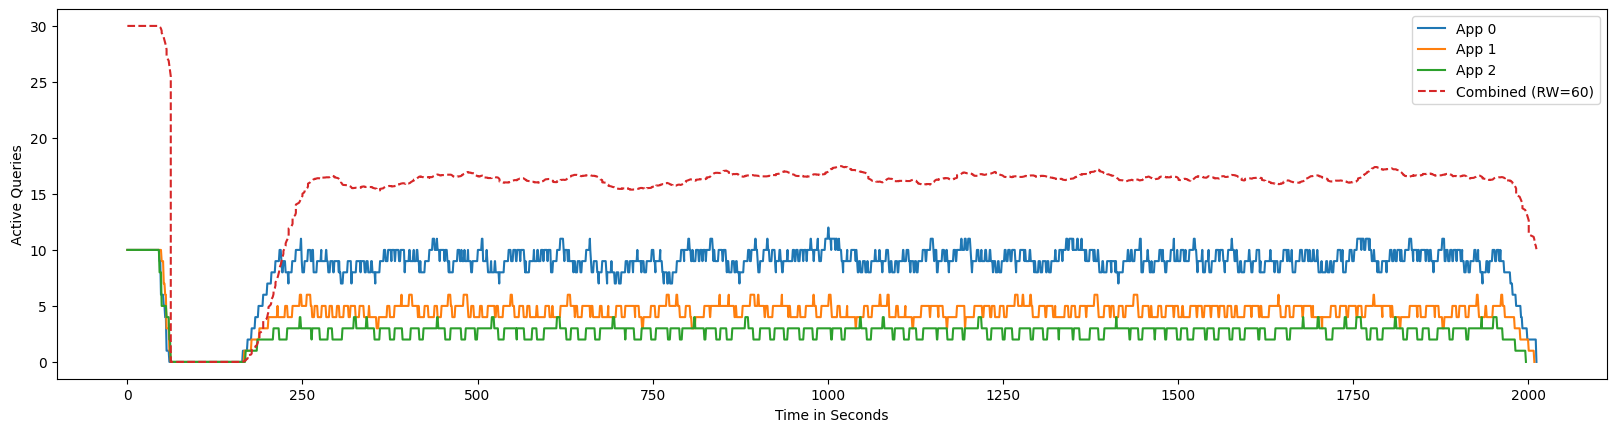

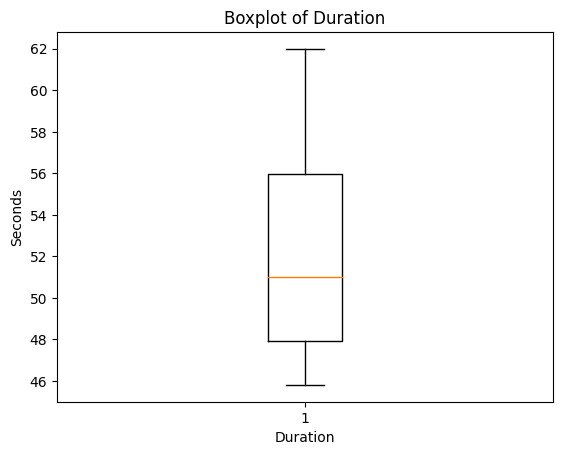

Saved to "../docker/workloads//constant-mixed-i18l60sf550d1800_4.csv"


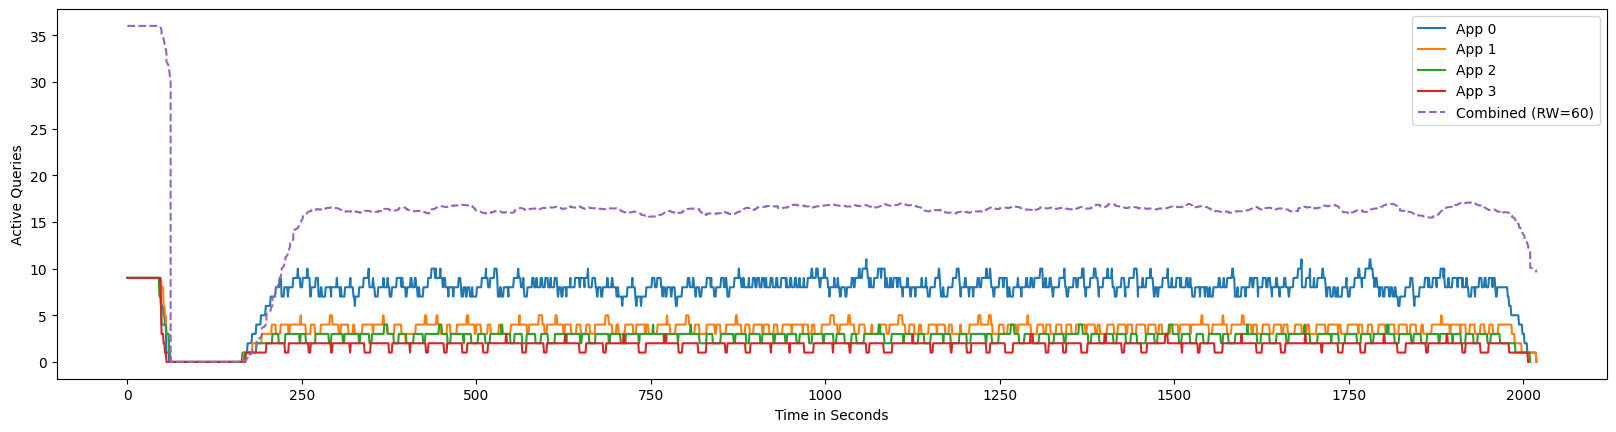

In [20]:
QUERY_DURATION = 55
QUERY_DURATION_BUFFER = 5
INTENSITY = {
    2: [14, 6],
    3: [10, 5, 3],
    4: [9, 4, 3, 2]
}
QUERY_SCALE_FACTOR=DEF_SCALE_FACTOR
DURATION=1800

for n in range(2, 5):
    constant = create_constant2(
        queries,
        num_apps=n,
        duration=DURATION,
        query_duration=QUERY_DURATION,
        query_duration_buffer=QUERY_DURATION_BUFFER,
        intensity=INTENSITY[n],
        app_offset=(QUERY_DURATION + QUERY_DURATION_BUFFER) / n / INTENSITY[n][0],
        query_duration_var=10,
        query_interval_var=1,
        initial_delay=3*QUERY_DURATION,
        warm_up=INTENSITY[n][0],
        query_scale_factor=QUERY_SCALE_FACTOR,
        rand_seed=0
    )
    print_timeline_info(constant)
    plot_durations(constant)
    plot_timeline(constant, rolling=60)
    save_timeline(constant, f'constant-mixed-i{sum(INTENSITY[n])}l{QUERY_DURATION + QUERY_DURATION_BUFFER}sf{QUERY_SCALE_FACTOR * 100:.0f}d{DURATION}_{n}')


### Mixed

Bursty for 1 apps with seed: 0
Constant for 1 apps with seed: 0
Saved to "../docker/workloads//mixed-bi20bl60bb5bi2cl90ci10sf550d1800_2.csv"
Bursty for 2 apps with seed: 0
Constant for 1 apps with seed: 0
Saved to "../docker/workloads//mixed-bi18bl60bb5bi2cl90ci10sf550d1800_3.csv"
Bursty for 3 apps with seed: 0
Constant for 1 apps with seed: 0
Saved to "../docker/workloads//mixed-bi16bl60bb5bi2cl90ci10sf550d1800_4.csv"


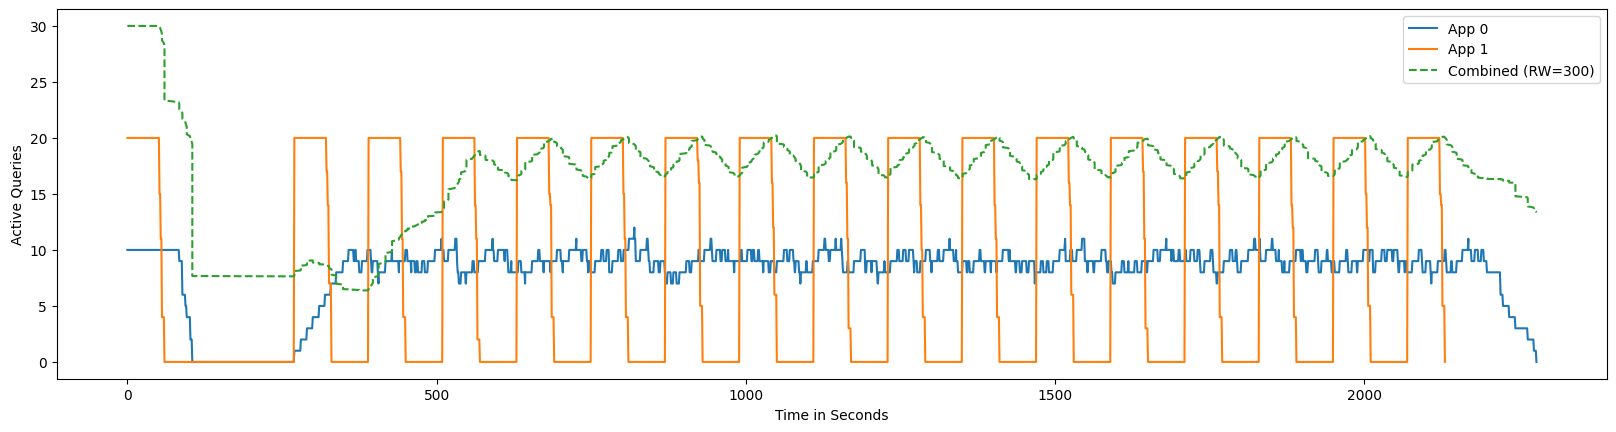

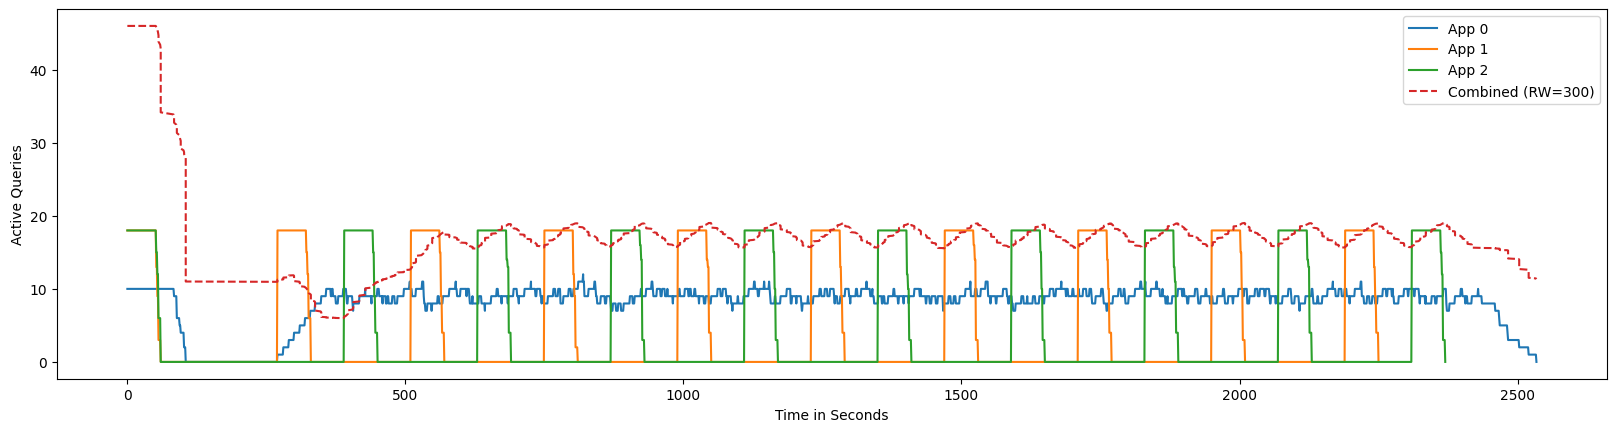

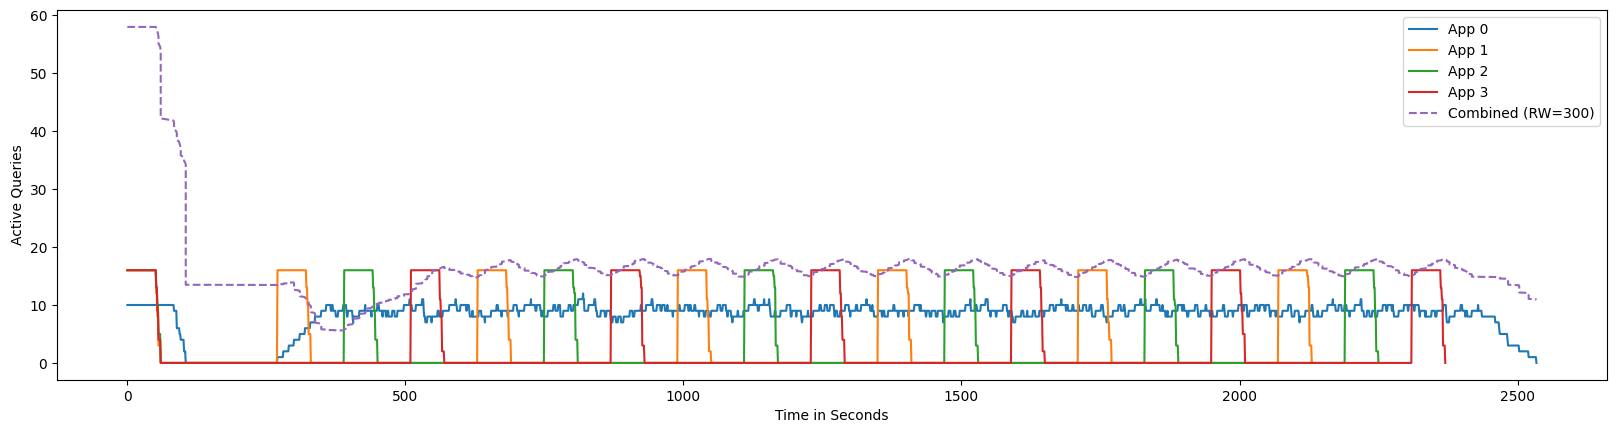

In [21]:
DURATION=1800
BURST_LEN=60
BURST_BUFFER=5
BURST_INTENSITY={
    2: 20,
    3: 18,
    4: 16
}
BURST_INTERVAL=2
QUERY_SCALE_FACTOR=DEF_SCALE_FACTOR
CONSTANT_QUERY_LEN=90
CONSTANT_INTENSITY=10


for n in range(2, 5):
    burst_interval = 2 * (BURST_LEN) * (n - 1)
    burst_count = int(math.ceil(DURATION / burst_interval) + 1)
    bursts = create_bursty2(
        queries,
        num_apps=n-1,
        app_offset=burst_interval / (n - 1),
        burst_count=burst_count,
        burst_intensity=BURST_INTENSITY[n],
        burst_interval=burst_interval,
        burst_start_var=0,
        query_duration=BURST_LEN - BURST_BUFFER,
        query_duration_var=5,
        query_scale_factor=QUERY_SCALE_FACTOR,
        initial_delay=3 * 90,
        warm_up=BURST_INTENSITY[n],
        rand_seed=0
    )
    constant = create_constant2(
        queries,
        num_apps=1,
        duration=burst_count * burst_interval,
        intensity=10,
        app_offset=0,
        query_duration=CONSTANT_QUERY_LEN,
        query_duration_buffer=CONSTANT_INTENSITY,
        query_duration_var=15,
        query_scale_factor=QUERY_SCALE_FACTOR,
        initial_delay=3 * CONSTANT_QUERY_LEN,
        warm_up=CONSTANT_INTENSITY,
        rand_seed=0
    )

    bursts['app'] = bursts['app'] + 1

    mixed = pd.concat([constant, bursts])
    plot_timeline(mixed, 300)
    # f'i{intensity}bl{burst_len}bb{burst_buffer}sf{scale_factor * 100:.0f}d{total_len}_{num_apps}'
    save_timeline(mixed, f'mixed-bi{BURST_INTENSITY[n]}bl{BURST_LEN}bb{BURST_BUFFER}bi{BURST_INTERVAL}cl{CONSTANT_QUERY_LEN}ci{CONSTANT_INTENSITY}sf{QUERY_SCALE_FACTOR * 100:.0f}d{TOTAL_LEN}_{n}')

## Analyze Traces

In [22]:
DIR_TRACES = '../data/workload-traces'

In [23]:
def get_trace(name, start):
    dir = f"{DIR_TRACES}/{name}/{start}/"
    file_list = os.listdir(dir)
    
    trace = pd.DataFrame()

    for file_name in file_list:
        if file_name.endswith('.csv'):
            trace_app = pd.read_csv(f'{dir}/{file_name}')
            trace = pd.concat([trace, trace_app], ignore_index=True)
            
    return trace

def plot_traces(trace, rolling=None):
    trace = trace.copy()
    trace['start'] = trace['start'] / 1000
    trace['duration'] = trace['duration'] / 1000
    trace = trace.sort_values(['app', 'start'])
    # display(trace)
    plot_timeline(trace,rolling=rolling)

def plot_duration(trace):
    plt.figure()  # Create a new plot
    plt.boxplot(trace['duration'] / 1000, showfliers=True)
    plt.xlabel('Duration')
    plt.ylabel('Seconds')
    plt.title('Boxplot of Duration')
    plt.show()

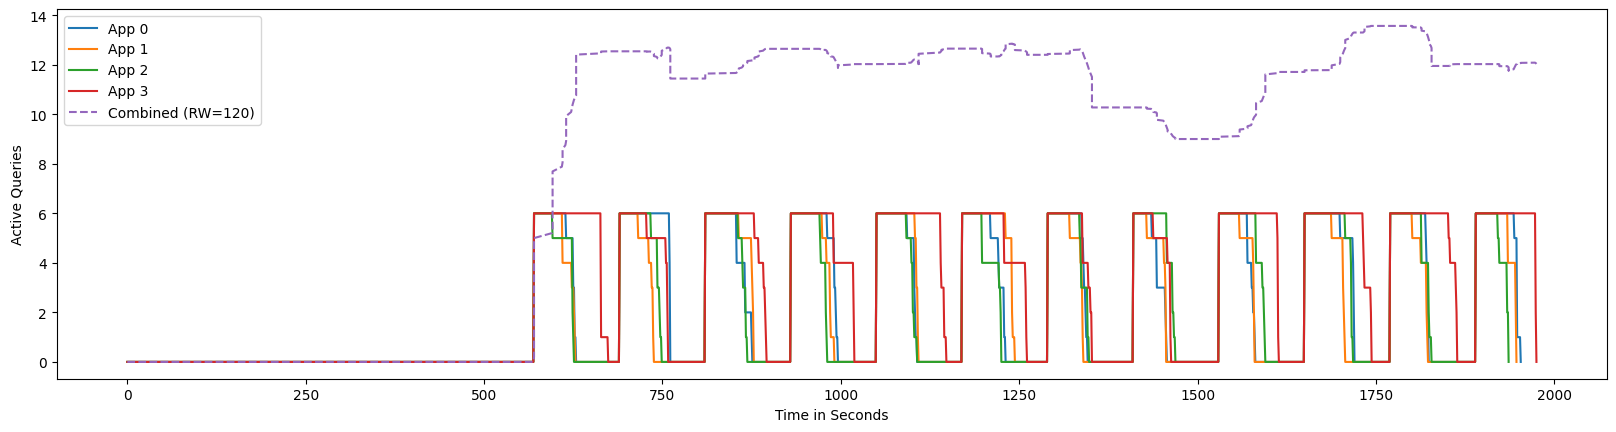

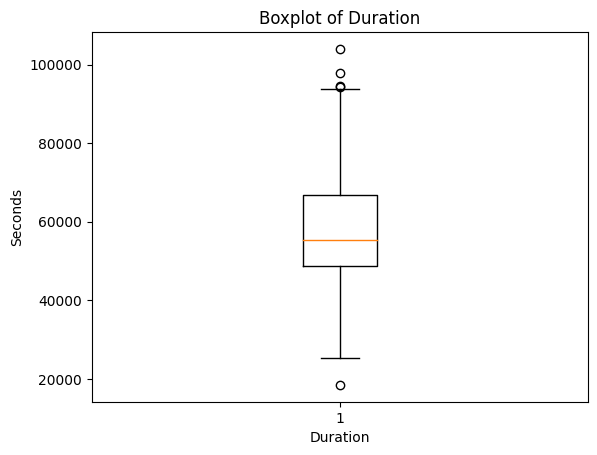

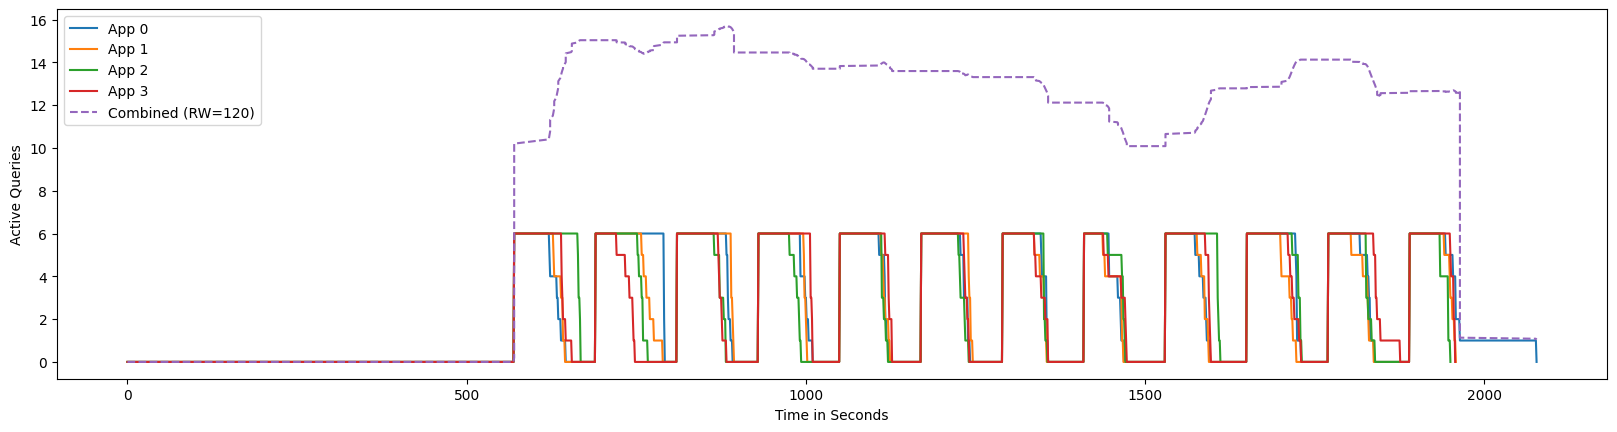

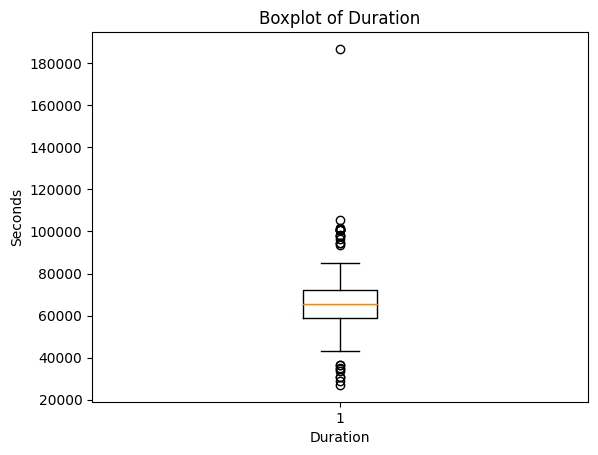

In [24]:

# trace = get_trace('bursty-spaced-i5d30s260_3', '1718049385')
# plot_traces(trace, 300)
# plot_durations(trace)

# # Good for 3
# trace = get_trace('bursty-spaced-i5d30s300_3', '1718050294')
# plot_traces(trace, 240)
# plot_durations(trace)

# Too little load:
# trace = get_trace('bursty-spaced-i5d30s500_4', '1718051894')
# plot_traces(trace, 120)
# plot_durations(trace)

# Good for 4
# trace = get_trace('bursty-spaced-i5d30s400_4', '1718052769')
# plot_traces(trace, 120)
# plot_durations(trace)


# trace = get_trace('bursty-spaced-i6d30s400_4', '1718054028')
# plot_traces(trace[trace['start'] > 400000], 120)
# plot_durations(trace[trace['start'] > 400000])

# static:
trace = get_trace('bursty-overlapping-i6d30s400_4', '1718158857')
trace = trace[trace['start'] >= 570000]
plot_traces(trace, 120)
plot_durations(trace)

# shared:
trace = get_trace('bursty-overlapping-i6d30s400_4', '1718169105')
trace = trace[trace['start'] >= 570000]
plot_traces(trace, 120)
plot_durations(trace)


# plot all 3 together

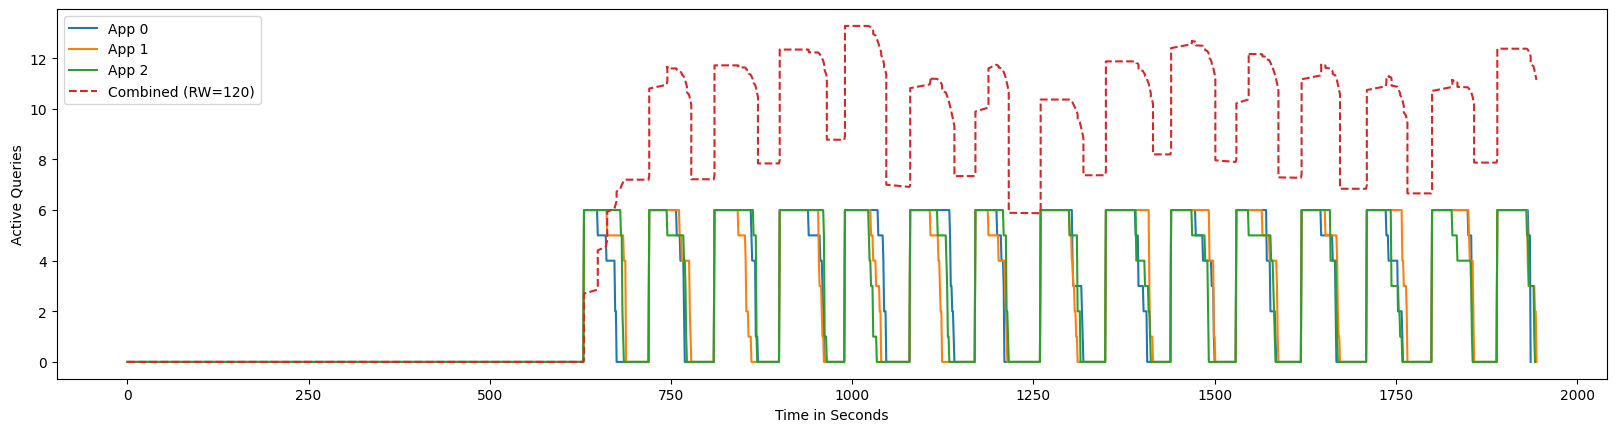

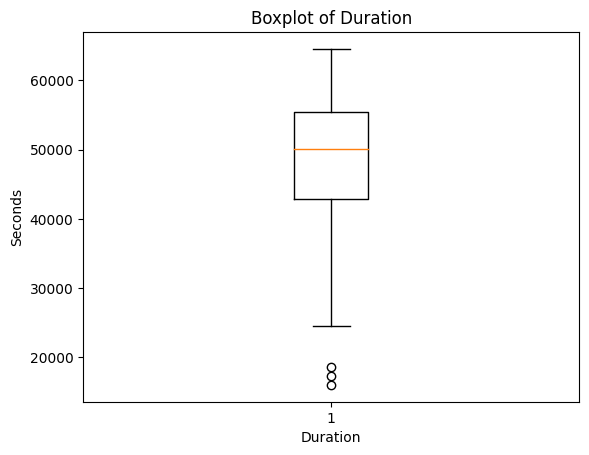

64550


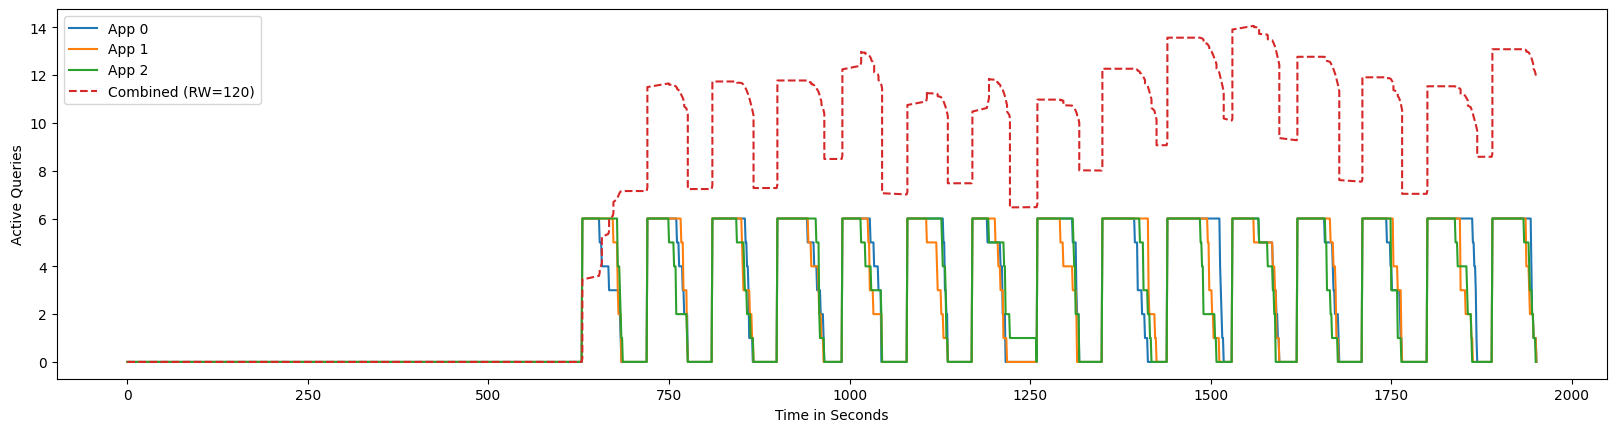

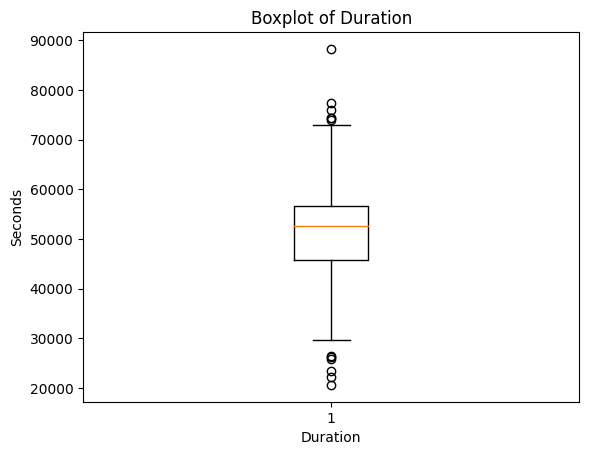

In [25]:

trace = get_trace('bursty-overlapping-i6d30s350_3', '1718156836')
trace = trace[trace['start'] >= 570000]
plot_traces(trace, 120)
plot_durations(trace)
print(trace['duration'].max())

# shared
trace = get_trace('bursty-overlapping-i6d30s350_3', '1718167078')
trace = trace[trace['start'] >= 570000]
plot_traces(trace, 120)
plot_durations(trace)

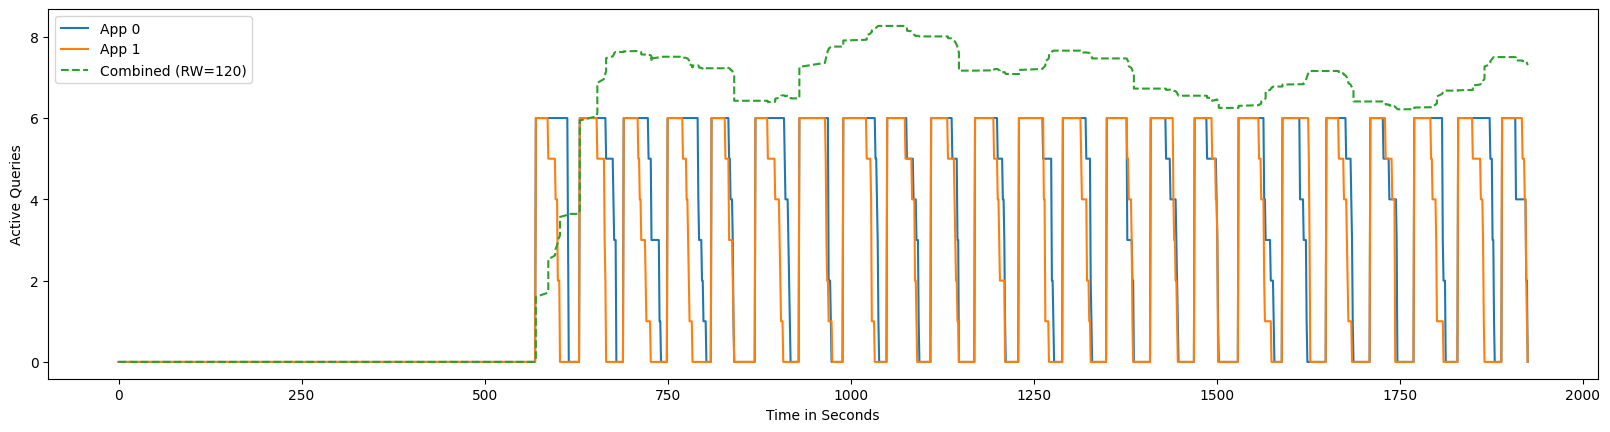

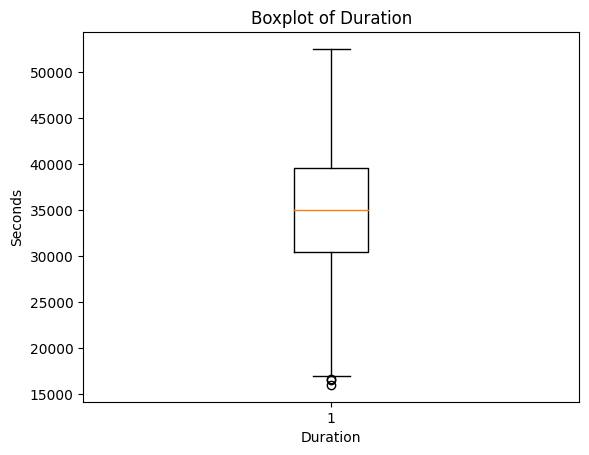

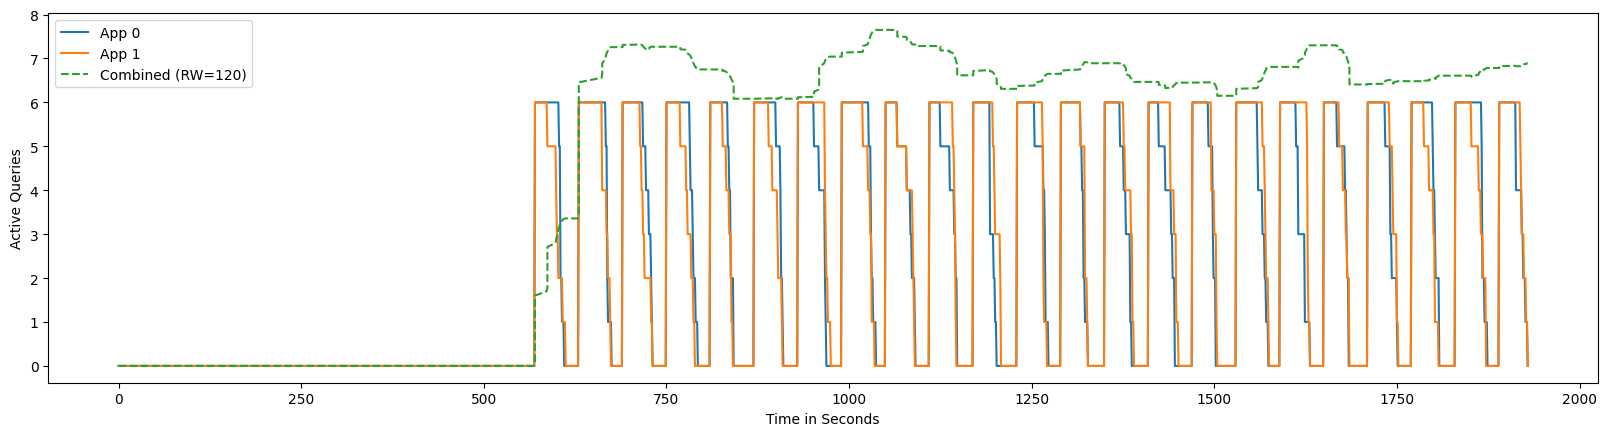

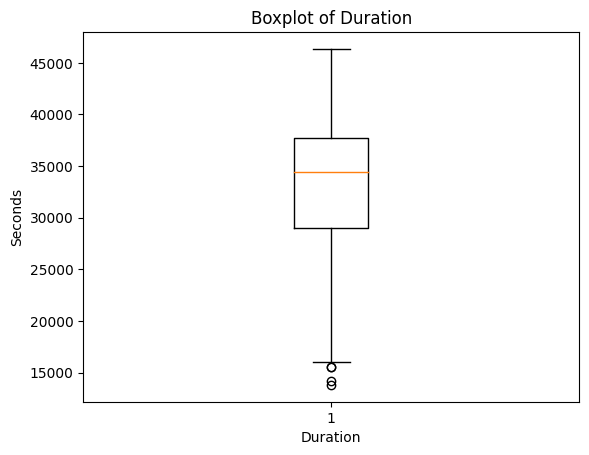

46343


In [26]:

trace = get_trace('bursty-overlapping-i6d30s350_2', '1718152781')
trace = trace[trace['start'] >= 570000]
plot_traces(trace, 120)
plot_durations(trace)

# shared
trace = get_trace('bursty-overlapping-i6d30s350_2', '1718162919')
trace = trace[trace['start'] >= 570000]
plot_traces(trace, 120)
plot_durations(trace)
print(trace['duration'].max())

In [27]:

trace = get_trace('bursty-spaced-i4d60s600_4','1718301841')
print(trace['duration'].max())
plot_traces(trace, 300)
# trace['duration'] = trace['duration'] / 1000
trace = trace[trace['start'] >= 500]
plot_durations(trace)
print(trace['duration'].median())

KeyError: 'duration'

In [29]:
def analyze(id:str, info="", warmup=150):
    print(info)
    id_parts = id.split('/')
    trace = get_trace(id_parts[0],id_parts[1])
    plot_traces(trace, 300)
    trace = trace[trace['start'] >= warmup * 1000]
    trace['duration'] = trace['duration'] / 1000
    plot_durations(trace)
    print(trace['duration'].median())

# Experiment Results

## 2024-06-13 (shitty)

### Constant

Static, empty cluster


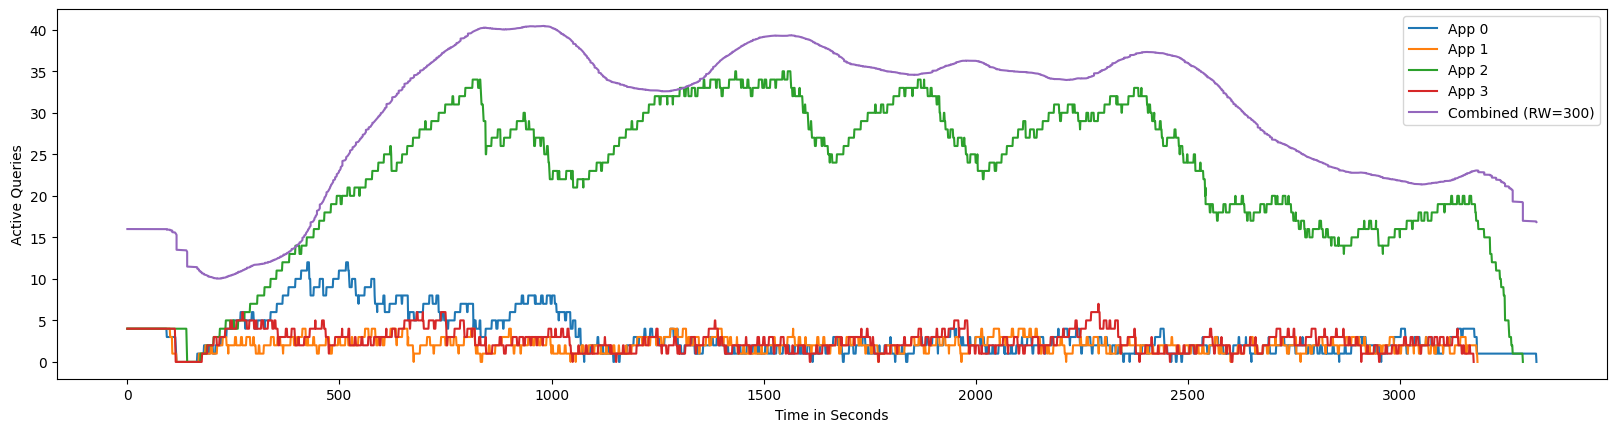

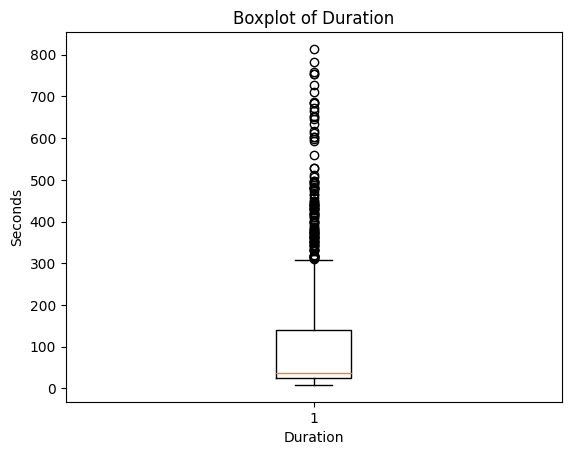

37.884
Shared, empty cluster


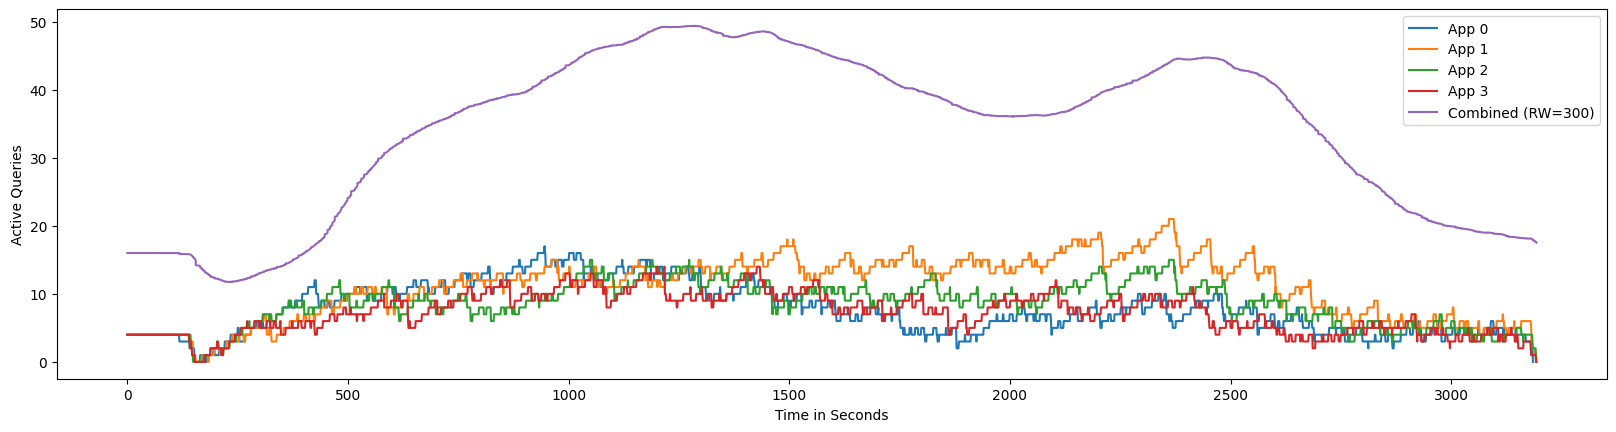

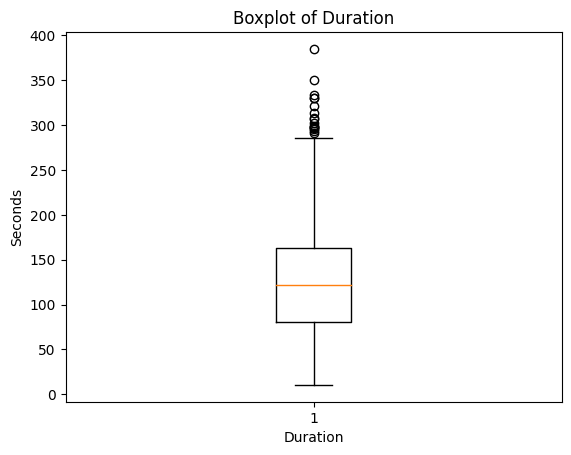

122.32


In [ ]:
analyze('constant-i4l60s550d3000_4/1718330812', 'Static, empty cluster')
analyze('constant-i4l60s550d3000_4/1718347563', 'Shared, empty cluster')

Static, empty cluster


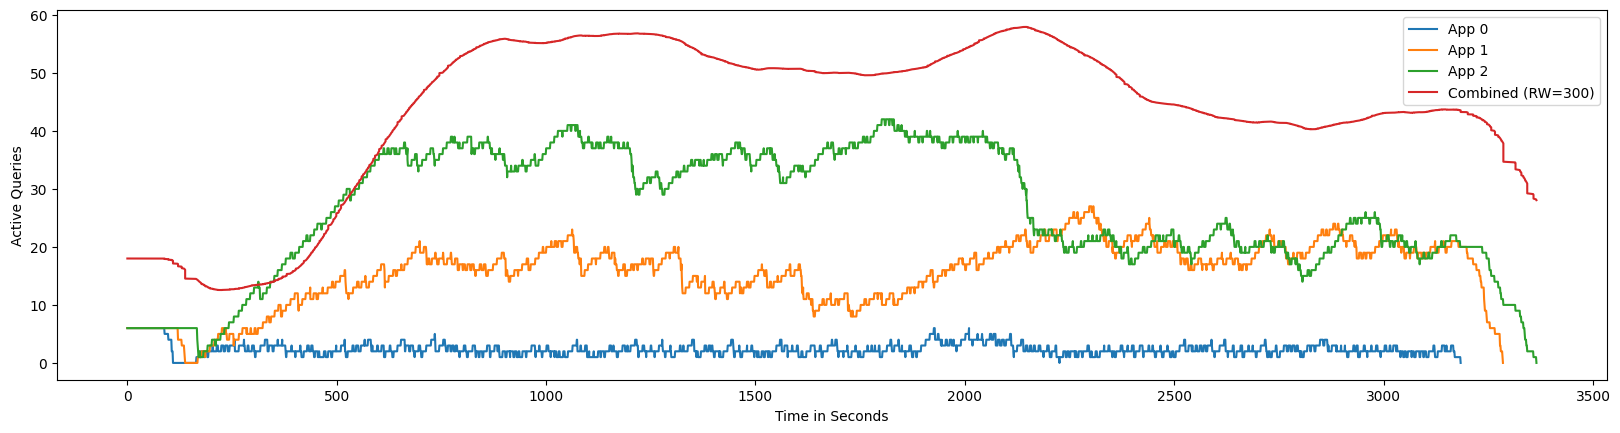

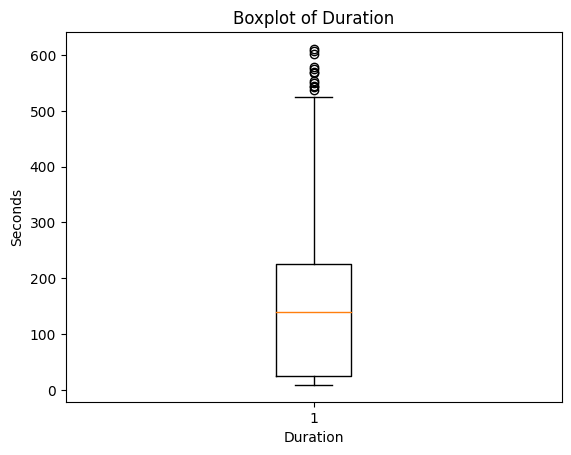

139.238
Shared, empty cluster


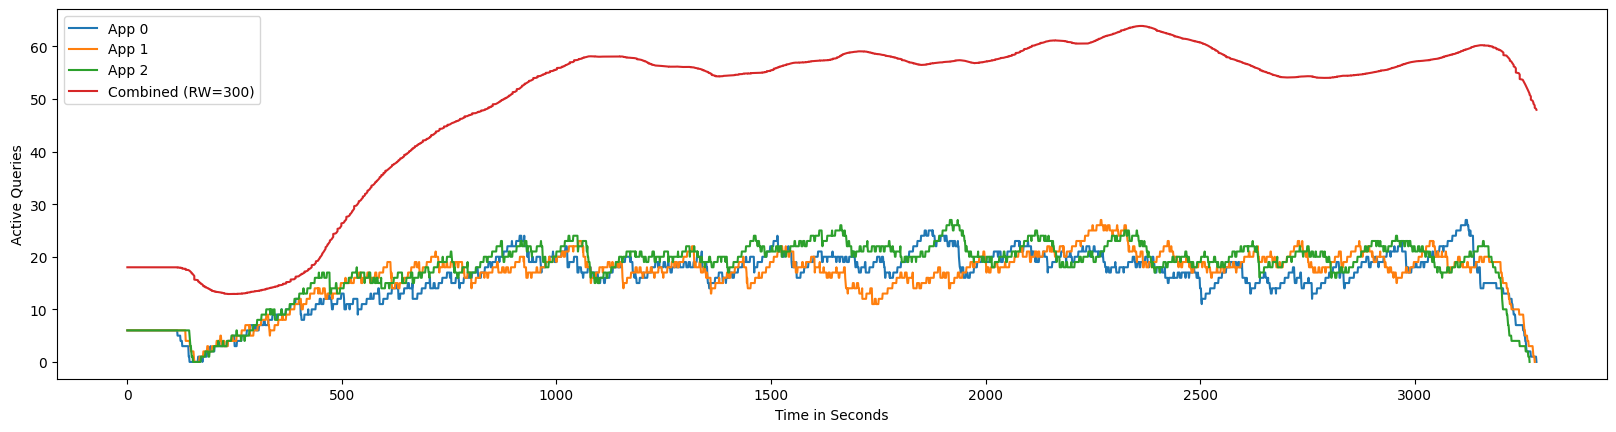

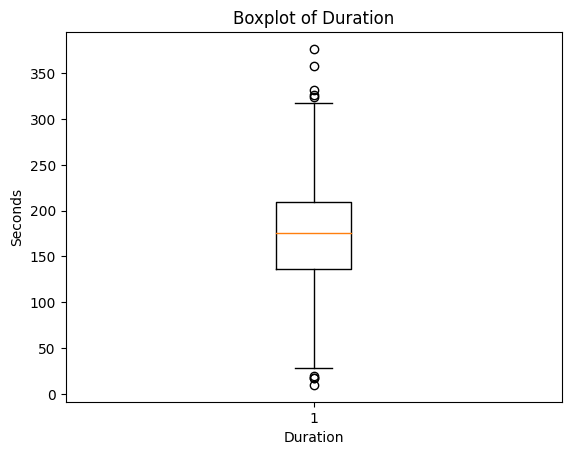

176.062


In [ ]:
analyze('constant-i6l60s550d3000_3/1718326058', 'Static, empty cluster')
analyze('constant-i6l60s550d3000_3/1718344173', 'Shared, empty cluster')

Static, empty cluster


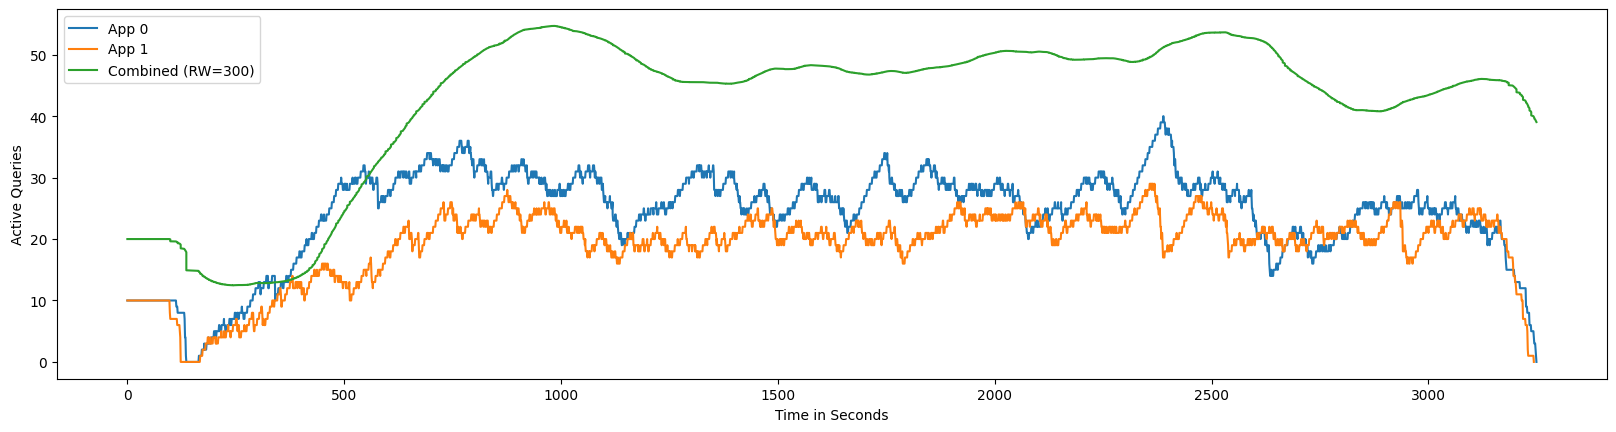

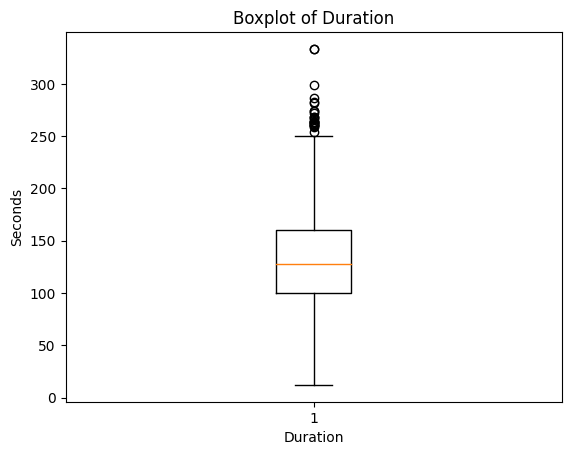

127.732
Shared, empty cluster


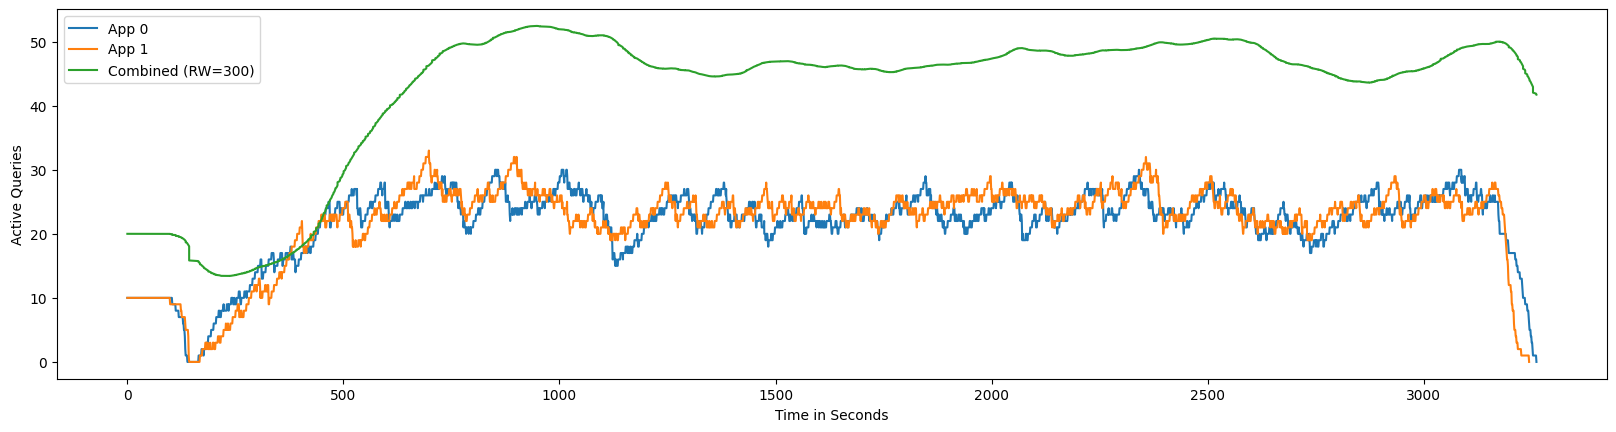

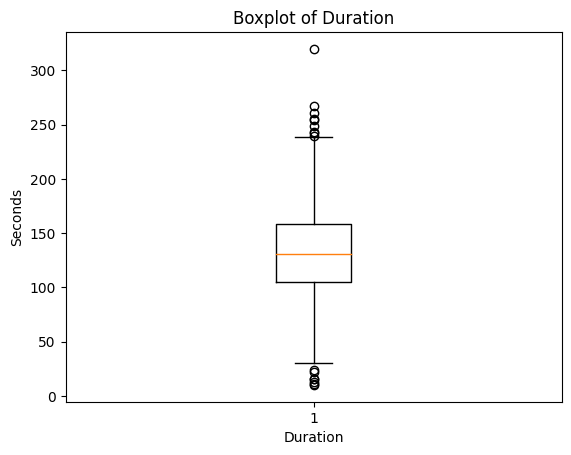

130.875


In [ ]:
analyze('constant-i10l60s550d3000_2/1718321798', 'Static, empty cluster')
analyze('constant-i10l60s550d3000_2/1718340302', 'Shared, empty cluster')

### Bursty Overlapping

Static


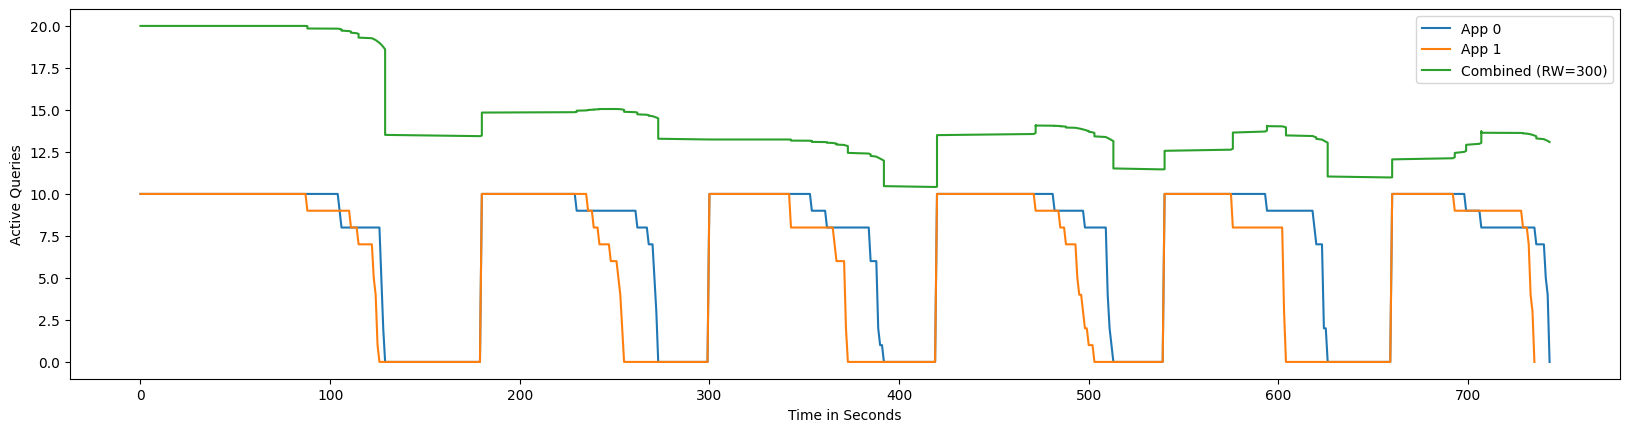

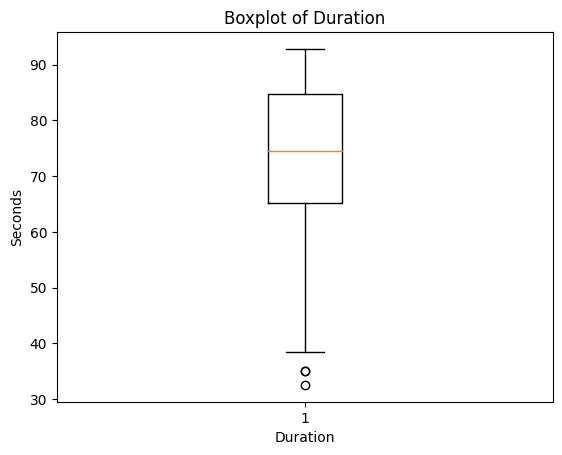

74.487
Static


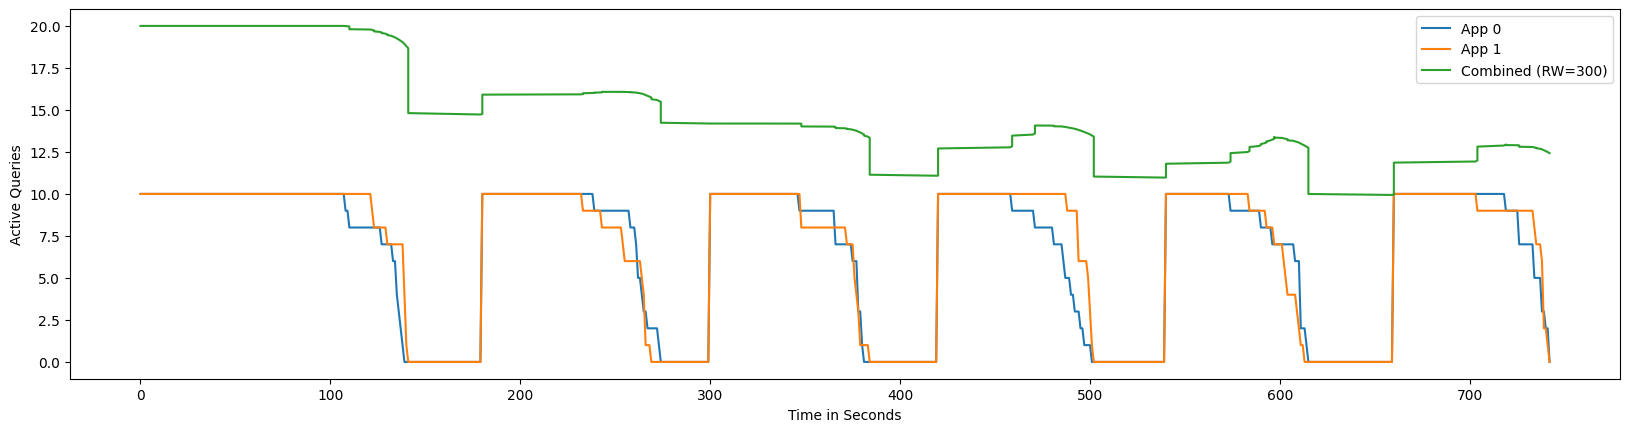

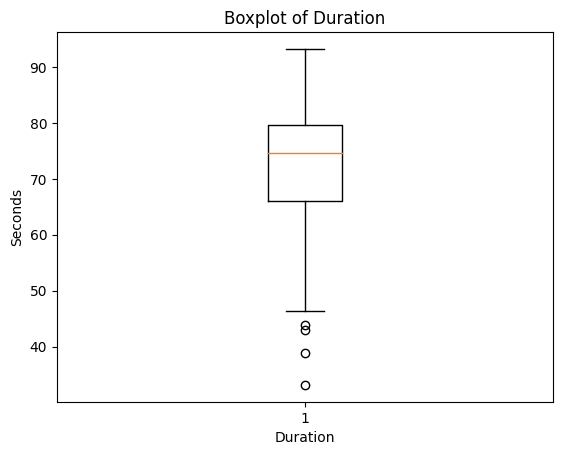

74.5675


In [ ]:
analyze('bursty-overlapping-i10l60b5s550d600_2/1718317360', 'Static')
analyze('bursty-overlapping-i10l60b5s550d600_2/1718335935', 'Shared')

Static


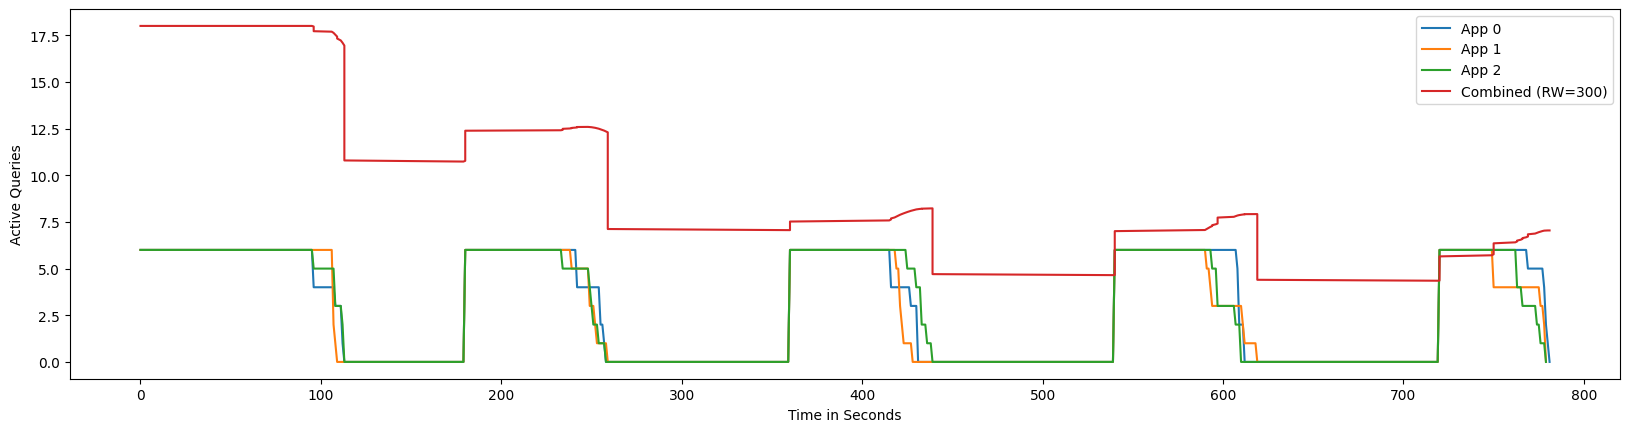

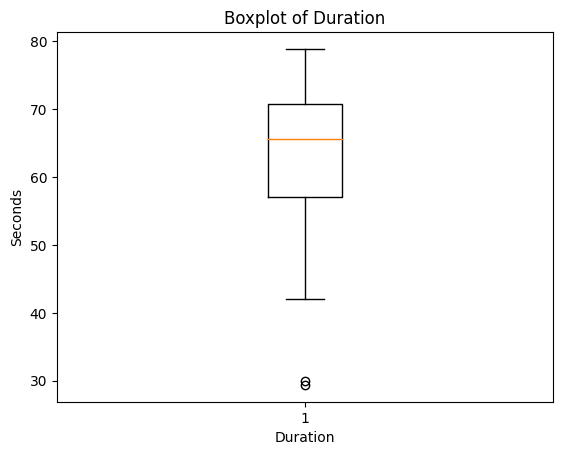

65.58250000000001
Shared


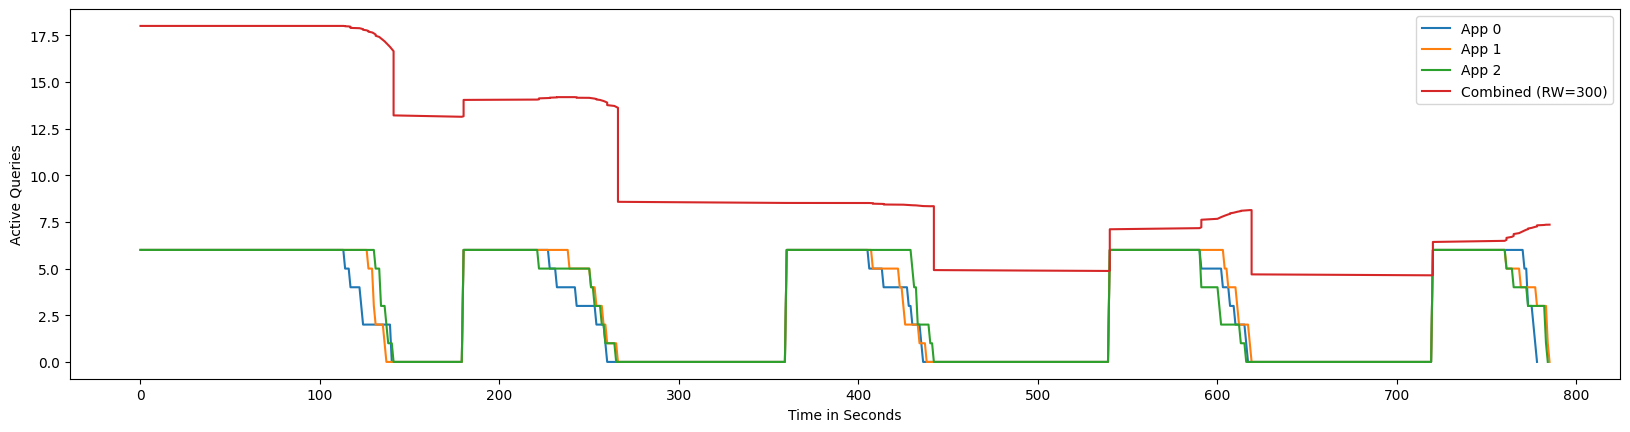

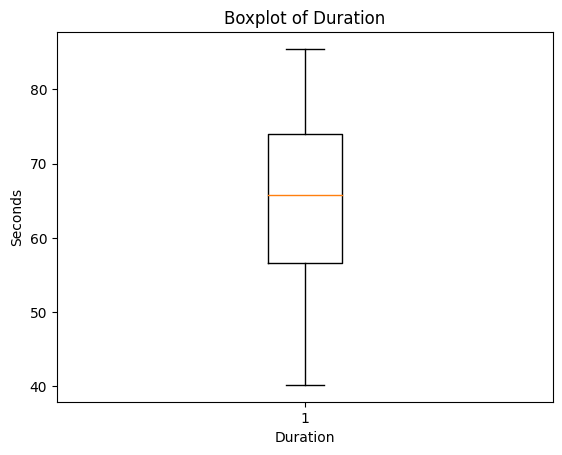

65.775


In [ ]:
analyze('bursty-overlapping-i6l60b5s600d600_3/1718319137', 'Static')
analyze('bursty-overlapping-i6l60b5s600d600_3/1718337694', 'Shared')

Static


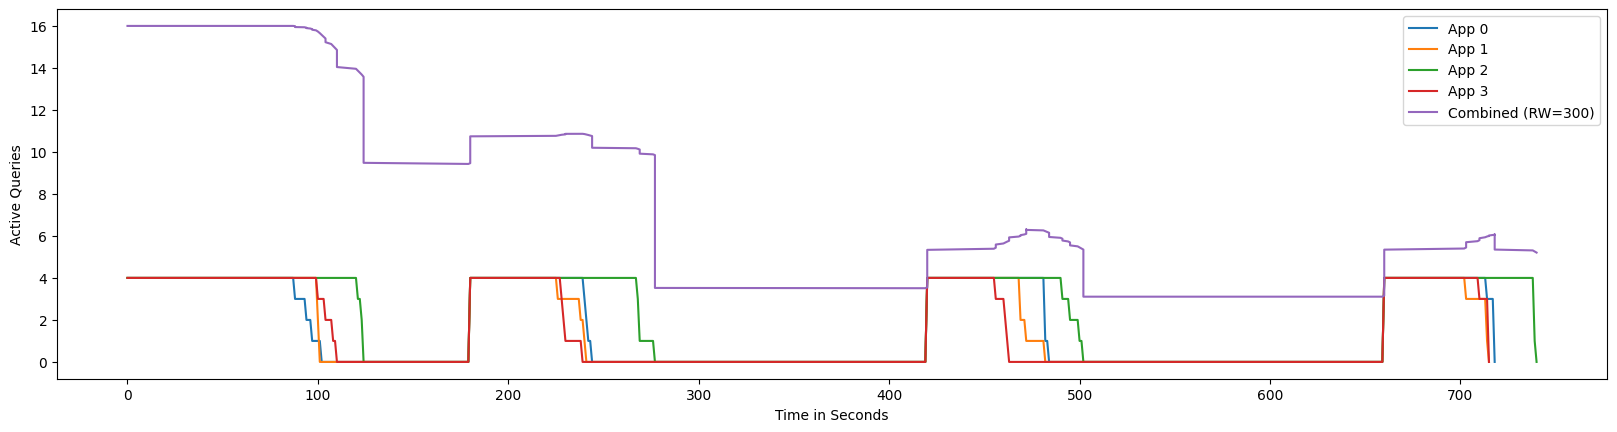

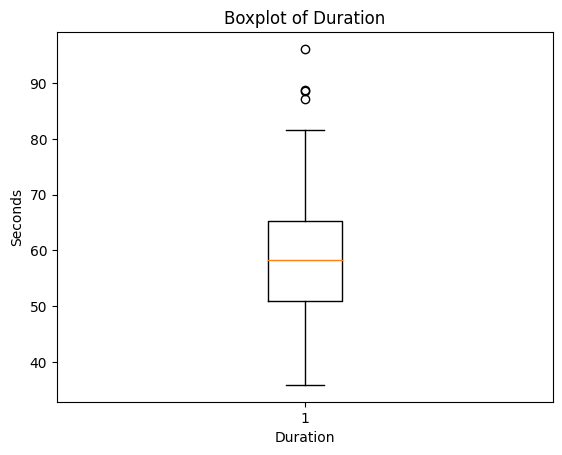

58.245000000000005
Shared


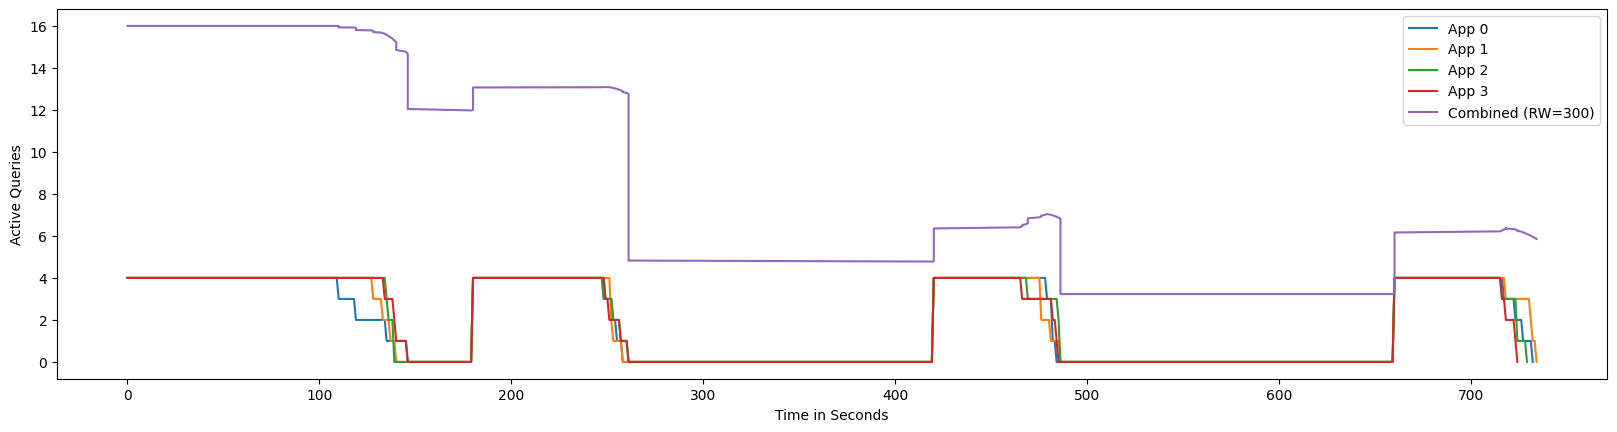

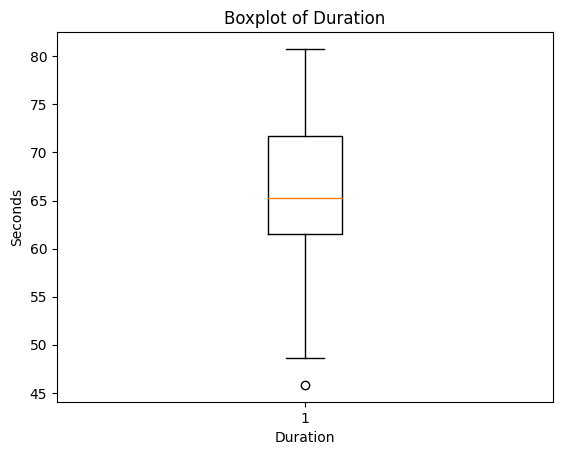

65.2635


In [ ]:
analyze('bursty-overlapping-i4l60b5s600d600_4/1718320985', 'Static')
analyze('bursty-overlapping-i4l60b5s600d600_4/1718339495', 'Shared')

### Bursty Spaced

In [ ]:
analyze('bursty-spaced-i10l60b5s550d600_2/1718316508', 'Static')
analyze('bursty-spaced-i10l60b5s550d600_2/1718334906', 'Shared')

NameError: name 'analyze' is not defined

Static


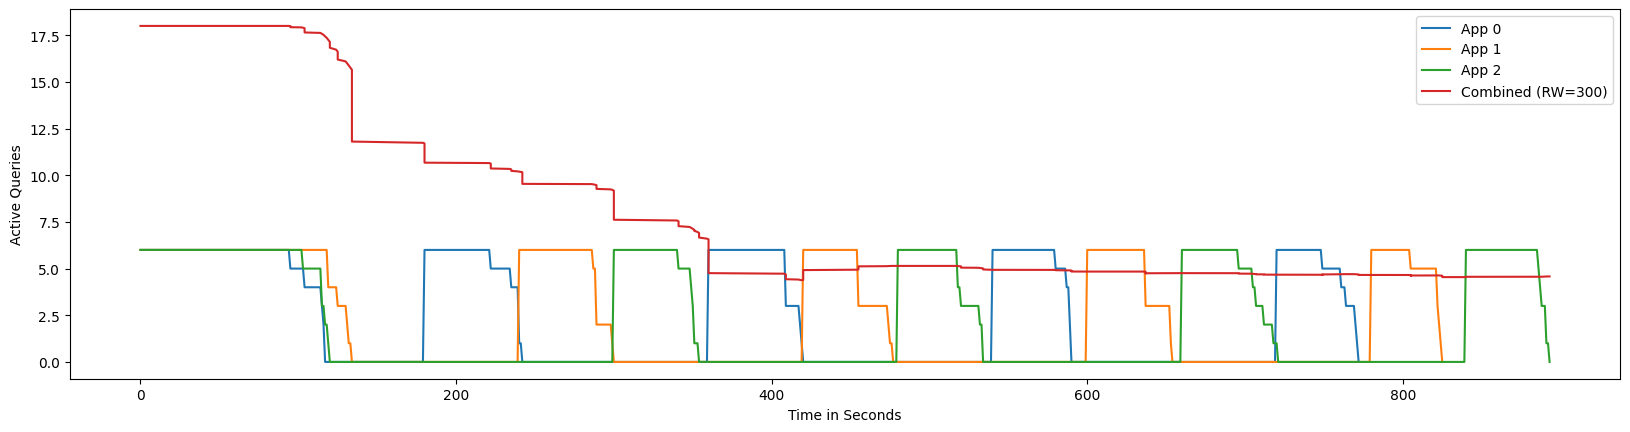

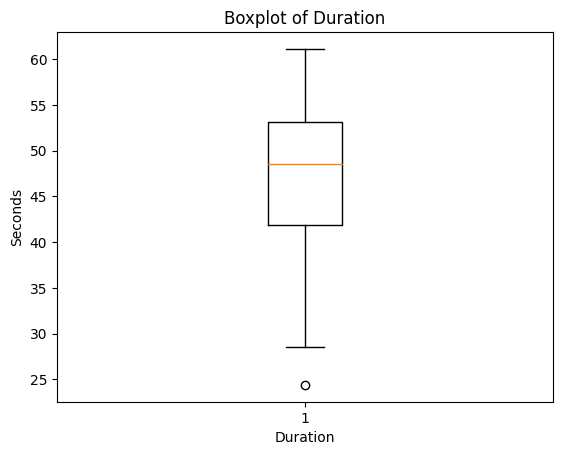

48.552
Shared


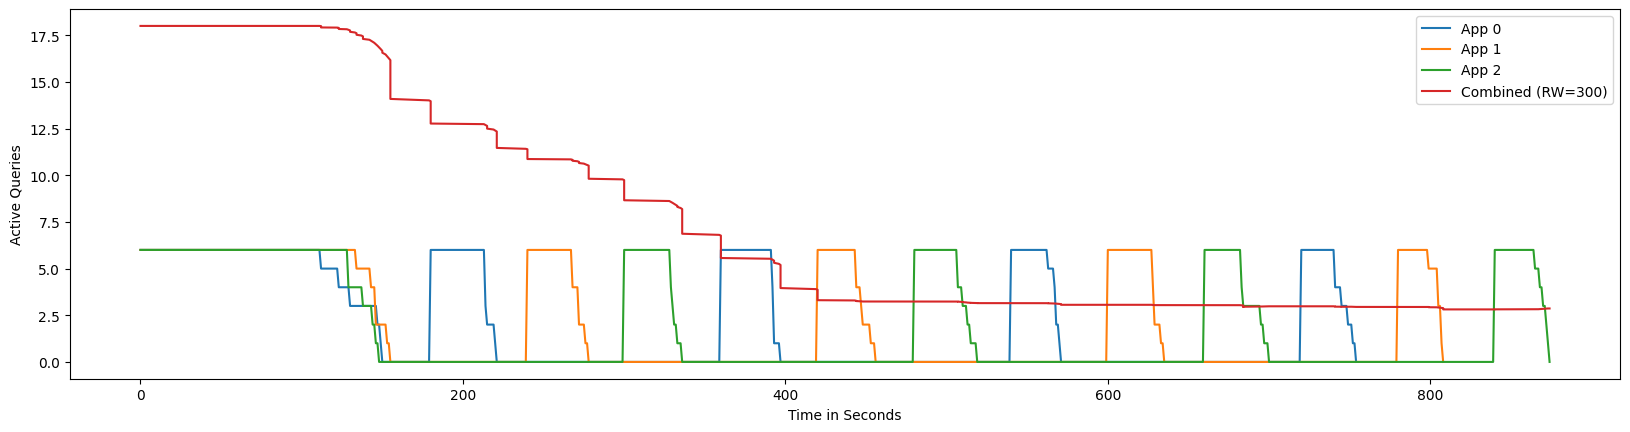

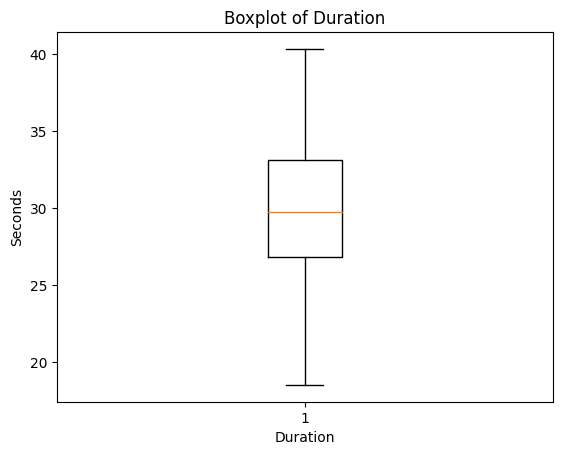

29.78


In [ ]:
analyze('bursty-spaced-i6l60b5s550d600_3/1718318173', 'Static')
analyze('bursty-spaced-i6l60b5s550d600_3/1718336749', 'Shared')

Static


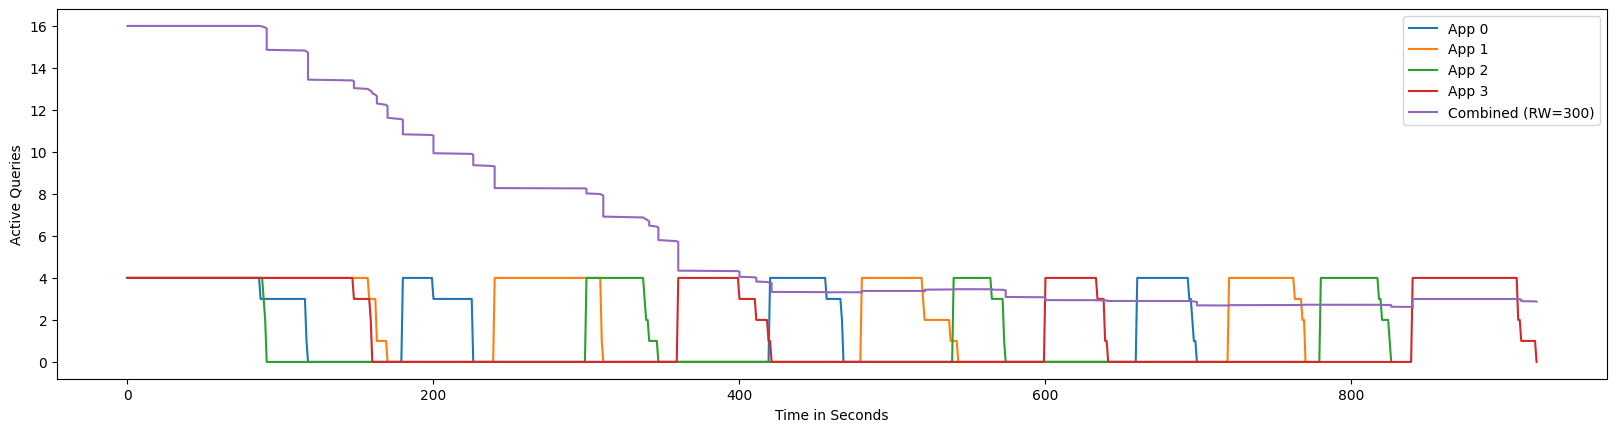

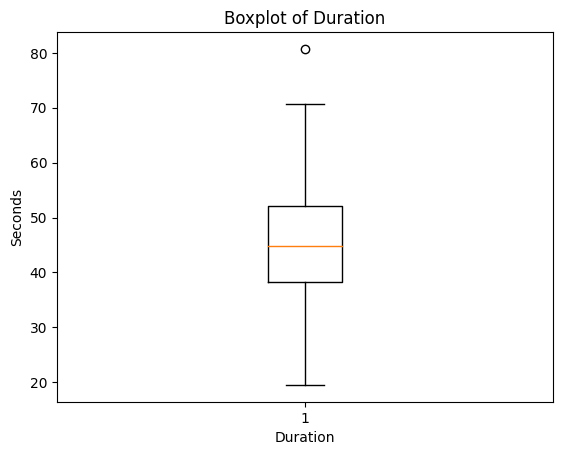

44.885
Shared


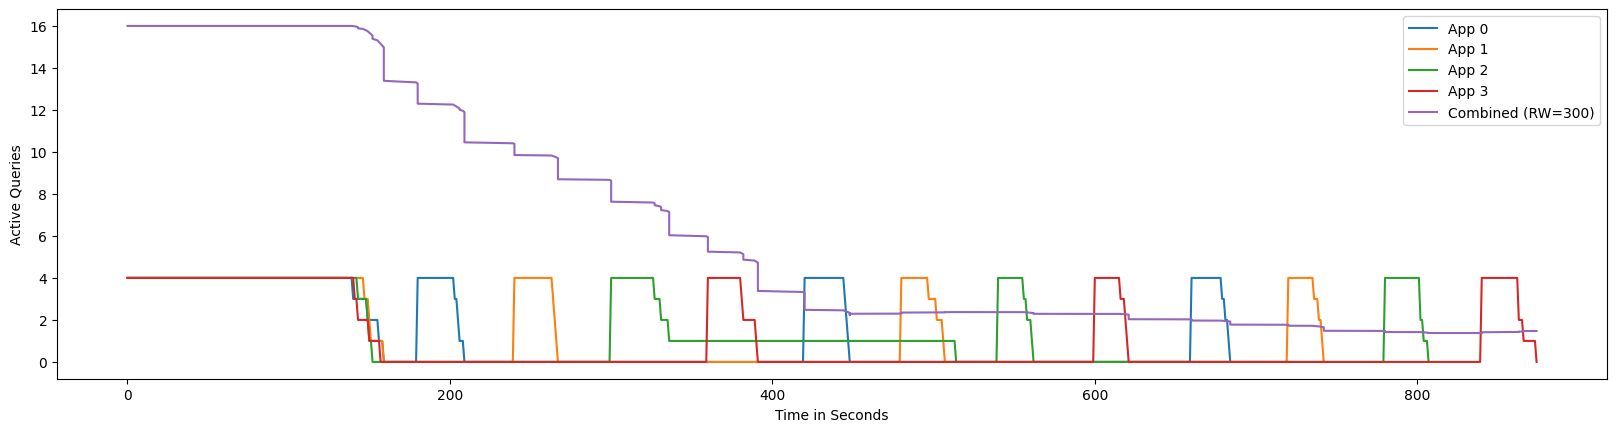

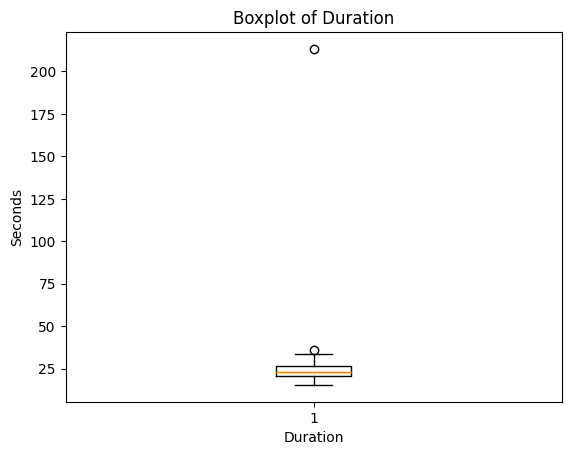

23.0815


In [ ]:
analyze('bursty-spaced-i4l60b5s550d600_4/1718319990', 'Static')
analyze('bursty-spaced-i4l60b5s550d600_4/1718338550', 'Shared')

## 2024-06-15

### Constant

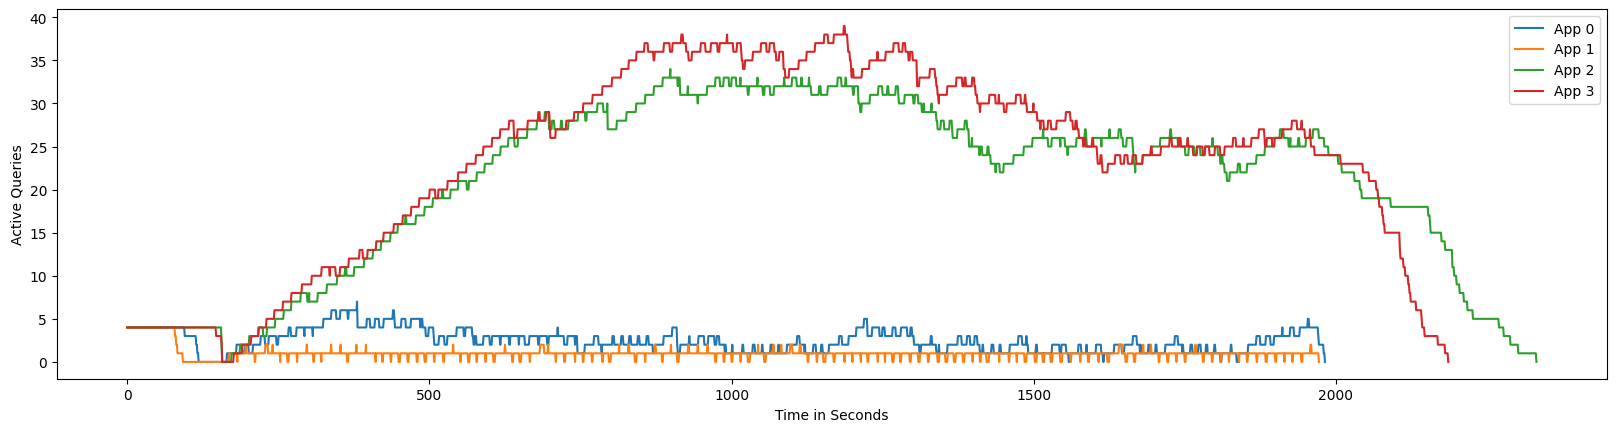

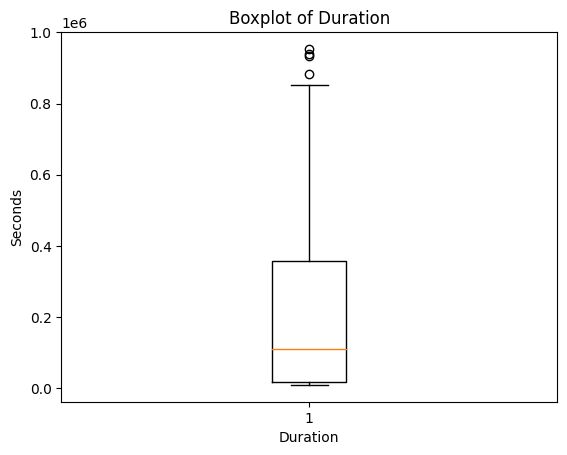

In [37]:
analyze('constant-i4qd60sf550d1800_4/1718418558', 'static')
analyze('constant-i4qd60sf550d1800_4/1718441237', 'shared')